In [38]:
# ==================================================== IMPORTS ===================================================
# Core data manipulation and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Markdown
import re
import os
import collections
# --------------------------------- Scikit-learn: Regression & Modeling ---------------------------------
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import linprog


# --------------------------------- Classical Statistics ---------------------------------
import statsmodels.formula.api as smf


In [39]:
#====================================================FIRST DELIVERABLE PART 1=============================
 

# Set Seaborn theme for better presentation
sns.set_theme(style="whitegrid")


#------------------------------------------------------- DATA LOADING ------------------------------------------------------


#Excel file path 
EXCEL_FILE_PATH = 'FINAL PROJECT.xlsx'

#List of sheet names to process from the master Excel file
ANALYSIS_SHEET_NAMES_RAW = [
    '2018-19 Montana Western', '2020-21 Westmont', '2021-22  Thomas More', 
    '2022-23 CLARKE', '2023-24 Dordt', '2024-25 Dordt', '2018-19 UPIKE', '2020-21 UPIKE', '2021-22 UPIKE', '2022-23 UPIKE', '2023-24 UPIKE', '2024-25 UPIKE'
]

#Normalize sheet names by removing leading/trailing whitespace
ANALYSIS_SHEET_NAMES = [name.strip() for name in ANALYSIS_SHEET_NAMES_RAW] 


#Row index where data headers start in each sheet
EXCEL_HEADER_ROW_INDEX = 8 

#Use dict to standarized naming across sheets
COLUMN_MAP = {
    'PEI season': 'PEI_40', 
    'Player': 'Player_Name',  
}


REQUIRED_COLS_CHECK = ['Player_Name', 'MIN', 'PEI_40', 'TS%', 'USG%', 'AST%', 'REB%', 'TOV%']#This are the required columns for this deliverable,
                                                                                             #this list acts as a 'safety check' to ensure uniform 
                                                                                             #column structure across all 12 data sheets 

#------------------------------------------------------- DATA EXTRACTION AND CONSOLIDATION LOOP ------------------------------------------------------


print(f"Starting player data processing across {len(ANALYSIS_SHEET_NAMES)} sheets...") #Print signal for start of multi-sheet data processing
                                                                                       
 
all_player_data = [] #List to collect processed data from each sheet
for sheet_name in ANALYSIS_SHEET_NAMES:
    try:
        #THIS IS FOR EACH SHEET -- load it into a temporary df
        df = pd.read_excel(EXCEL_FILE_PATH, sheet_name=sheet_name,header=EXCEL_HEADER_ROW_INDEX)
        df.columns = df.columns.str.strip() #Remove leading/trailing whitespace from column names
        df.rename(columns=COLUMN_MAP, inplace=True) #Renaming columns to ensure cross-sheet consistency

        #Fail-safe if sheets are missing; tell us which ones
        if not all(col in df.columns for col in REQUIRED_COLS_CHECK):
            missing_cols = [col for col in REQUIRED_COLS_CHECK if col not in df.columns]
            raise KeyError(f"Missing required columns: {missing_cols}. Please verify capitalization and exact spelling against your Excel headers.")
            
        #Convert player names to string and remove invalid entries
        df['Player_Name'] = df['Player_Name'].astype(str)
        df = df[df['Player_Name'] != 'nan'].copy()

        #To be able to graph, identify and remove summary rows (team totals and opponent totals)
        #First we find totals and store them in the following 2 variables
        team_total_row_index = df[df['Player_Name'].astype(str).str.contains('TOTAL', case=False, na=False)].index[0]
        opponent_row_index = df[df['Player_Name'].astype(str).str.contains('OPPONENT', case=False, na=False)].index[0]
        #Drop the total and opponent rows, make a copy to avoid modifying the original,
        #and reset the index so rows are numbered continuously
        players_df_current = df.drop(index=[team_total_row_index, opponent_row_index]).copy().reset_index(drop=True)
        players_df_current['Team_Sheet'] = sheet_name # add a column to identify the sheet

        
        #Convert core stats to int for calculations
        core_rate_cols = ['MIN','PEI_40', 'TS%', 'USG%', 'AST%', 'REB%', 'TOV%'] 
        for col in core_rate_cols:
            # We use .get to safely try to access the column name if it exists after the rename
            players_df_current[col] = pd.to_numeric(players_df_current.get(col, 0), errors='coerce').fillna(0)
            
        #Convert additional stats to int if present
        other_rate_cols = ['#', 'GP', 'GS', 'MIN_AVG', 'FG',
       'FGA', 'FG%', '3FG', '3FGA', '3FG%', 'eFG%', 'FT', 'FTA', 'FT%', 'OFF',
       'DEF', 'TOT', 'REB_AVG', 'PF', 'AST', 'AST/G', 'TO', 'TO/G', 'AST/TO',
       'BLK', 'BLK/G', 'ST', 'STL/G', 'PTS', 'PTS_AVG','STL%', 'BLK %', 'STOCKS'] 
        for col in other_rate_cols:
            # We use .get to safely try to access the column name if it exists after the rename
            players_df_current[col] = pd.to_numeric(players_df_current.get(col, 0), errors='coerce').fillna(0) 
        all_player_data.append(players_df_current.copy())
        
        
        print(f"   -> Successfully processed ALL metrics for {sheet_name}")

    except Exception as e:
        print(f"   -> ERROR processing sheet '{sheet_name}'. Skipping. Details: {e}")
        continue



#Convert additional stats to int if present
master_player_df = pd.concat(all_player_data, ignore_index=True)

#Save cleaned data for later use
master_player_df.to_csv('master_player_analysis_FULL.csv', index=False)
print("\n--- CONSOLIDATION COMPLETE ---")
print(f"Master Player DataFrame created with {len(master_player_df)} player-seasons.")
print("Data saved to 'master_player_analysis_FULL.csv' (includes all original stats).") #fancy prints


print(master_player_df)







Starting player data processing across 12 sheets...
   -> Successfully processed ALL metrics for 2018-19 Montana Western
   -> Successfully processed ALL metrics for 2020-21 Westmont
   -> Successfully processed ALL metrics for 2021-22  Thomas More
   -> Successfully processed ALL metrics for 2022-23 CLARKE
   -> Successfully processed ALL metrics for 2023-24 Dordt
   -> Successfully processed ALL metrics for 2024-25 Dordt
   -> Successfully processed ALL metrics for 2018-19 UPIKE
   -> Successfully processed ALL metrics for 2020-21 UPIKE
   -> Successfully processed ALL metrics for 2021-22 UPIKE
   -> Successfully processed ALL metrics for 2022-23 UPIKE
   -> Successfully processed ALL metrics for 2023-24 UPIKE
   -> Successfully processed ALL metrics for 2024-25 UPIKE

--- CONSOLIDATION COMPLETE ---
Master Player DataFrame created with 175 player-seasons.
Data saved to 'master_player_analysis_FULL.csv' (includes all original stats).
        #        Player_Name Position    GP    GS  


--- GENERATING VISUALIZATIONS FOR ALL 12 TEAMS ---



### Player Performance Summary for 2018-19 Montana Western (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
5,Brianna King,1141,35.758,58.282,34.821,22.323,6.521,4.171
8,Mesa King,111,28.468,62.806,18.405,19.827,1.203,2.858
2,Britt Cooper,958,26.221,53.264,19.418,12.420,10.828,2.373
3,Cierra Lamey,1006,22.624,57.201,17.809,11.191,9.560,3.153
7,Savanna Bignell,584,22.397,62.202,19.646,15.454,4.096,4.436
4,Shannon Worster,633,21.738,60.923,16.732,19.998,4.027,3.091
6,Tori Anderson,803,19.427,50.064,18.679,12.798,4.400,2.305
0,Paige Holmes,1016,16.102,53.013,12.028,11.379,5.205,1.769
1,Brandy Bookout,219,16.073,53.079,17.750,8.002,1.327,4.104
9,Darby Schye,357,15.686,54.007,12.204,9.600,3.153,3.703


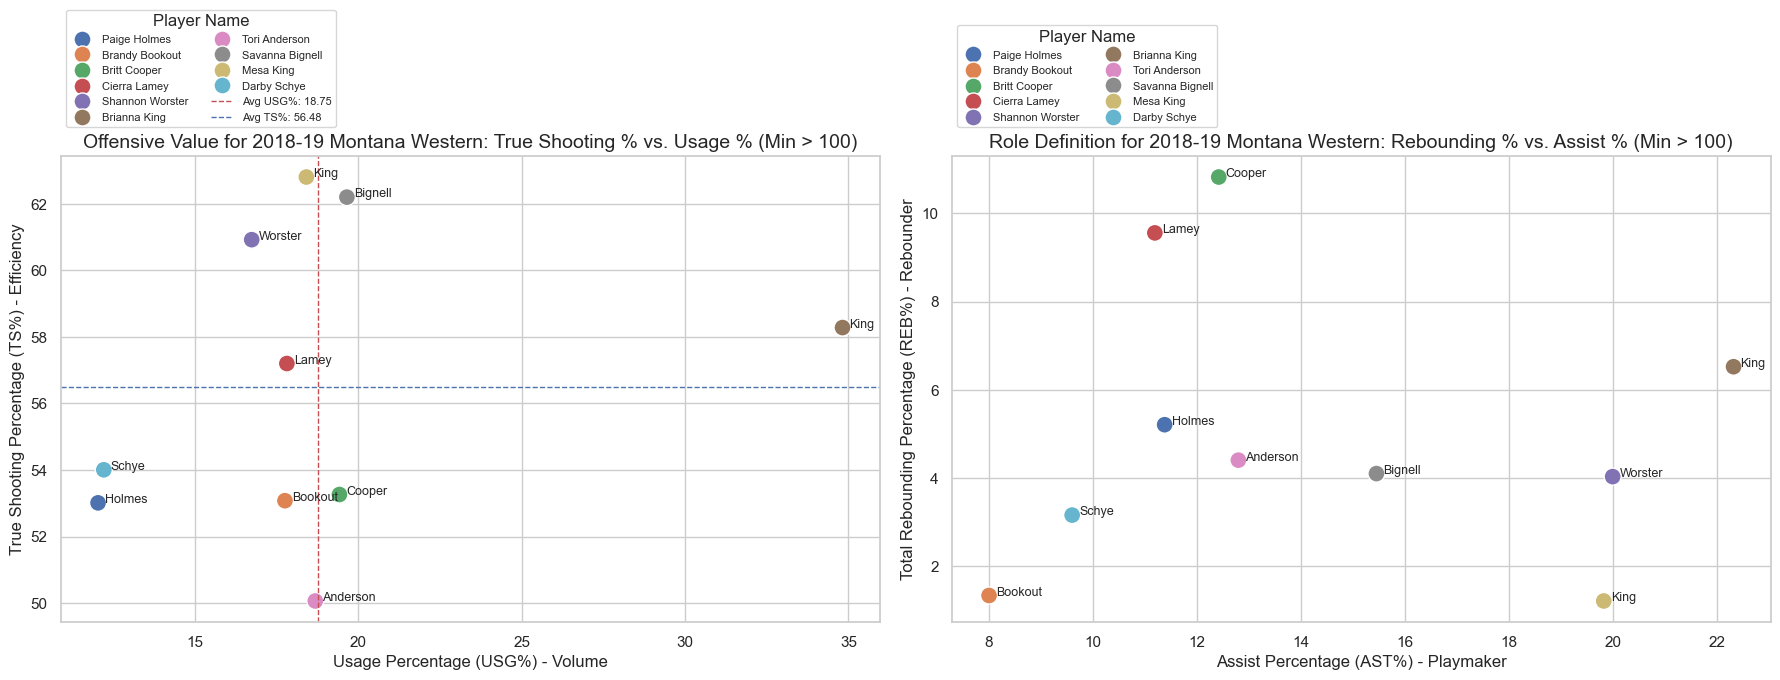


### Player Performance Summary for 2020-21 Westmont (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
10,"Berberabe, Stefanie",488,36.066,59.731,25.352,29.857,6.703,2.581
15,"Stoll, Gabriella",204,31.569,48.578,22.419,5.178,5.531,2.375
11,"Jarrett, Iyree",526,31.407,49.861,24.283,31.058,6.768,3.039
13,"Brown, Sydney",382,24.817,54.234,17.289,7.055,8.189,2.790
18,"Okonkwo, Destiny",197,24.772,44.553,18.317,2.444,4.761,3.689
14,"Larson, Kaitlin",405,23.407,42.111,14.757,5.757,9.783,0.837
12,"Tsuneishi, Lauren",524,22.595,60.989,17.937,7.633,3.446,1.109
17,"Miyahara, Krissy",233,15.966,65.641,13.166,8.841,1.036,2.079


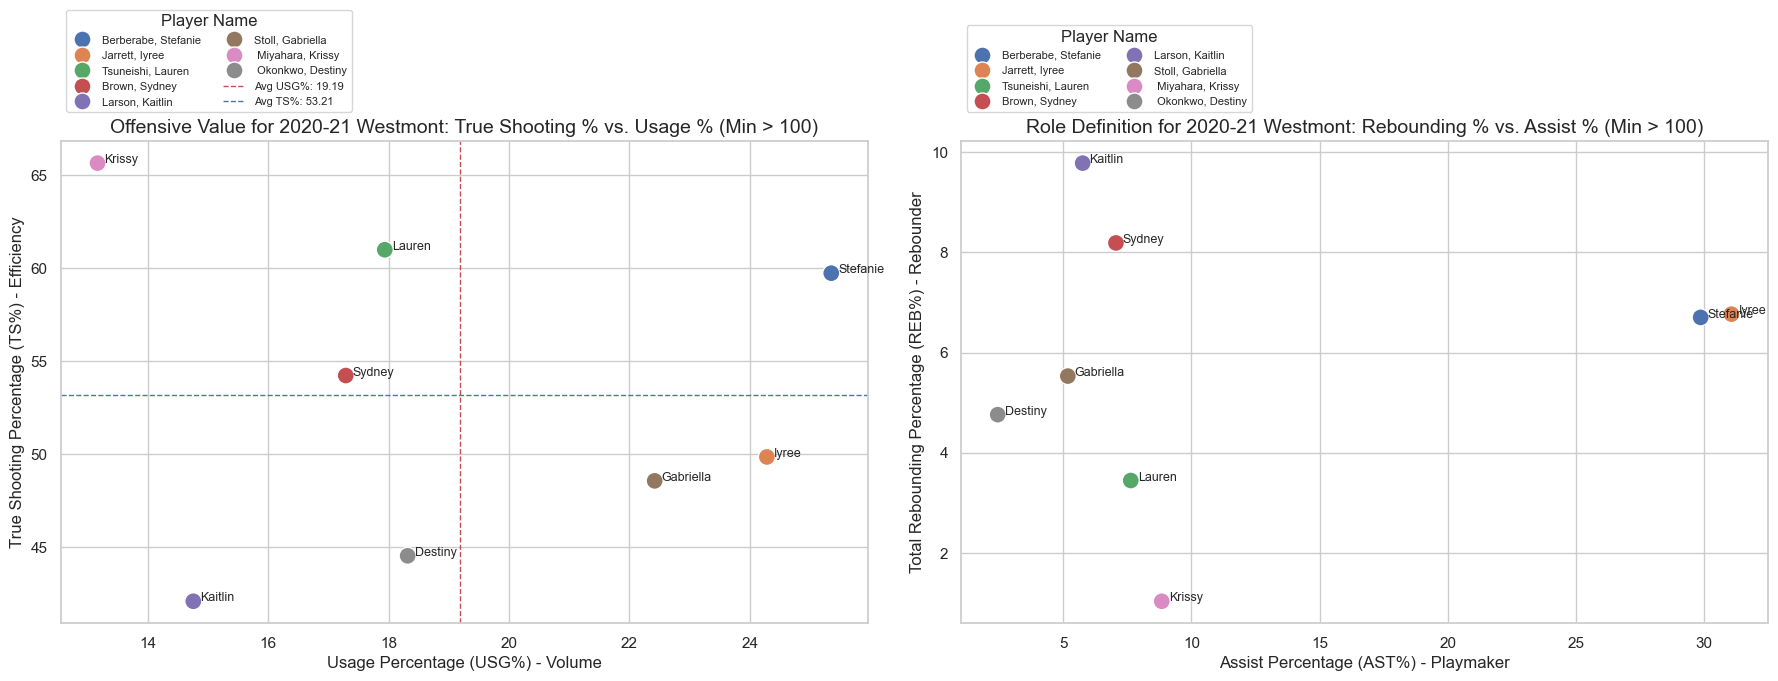


### Player Performance Summary for 2021-22  Thomas More (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
21,"Chrisman, Alexah",778,35.784,59.997,21.397,14.147,11.643,3.549
24,"Secrist, Summer",420,34.857,58.003,26.959,12.357,5.197,3.991
27,"Smith, Alex",630,30.921,57.966,19.932,12.299,7.827,2.113
20,"Clos, Taylor",662,28.520,55.927,26.172,21.016,3.732,3.202
22,"Simon, Emily",749,28.358,62.712,19.875,17.702,6.767,3.554
25,"Barth, Zoie",672,24.464,58.746,18.863,21.565,5.143,3.815
26,"Brenner, Kelly",609,22.200,59.321,19.956,8.085,2.687,1.943
29,"Schwarber, Kenzie",443,21.580,40.732,15.709,15.796,4.600,3.005
23,"Hurst, Courtney",880,21.136,48.471,20.383,10.415,4.477,2.353
32,"Whiteman, Sammi",177,20.113,62.753,17.380,13.354,1.130,3.621


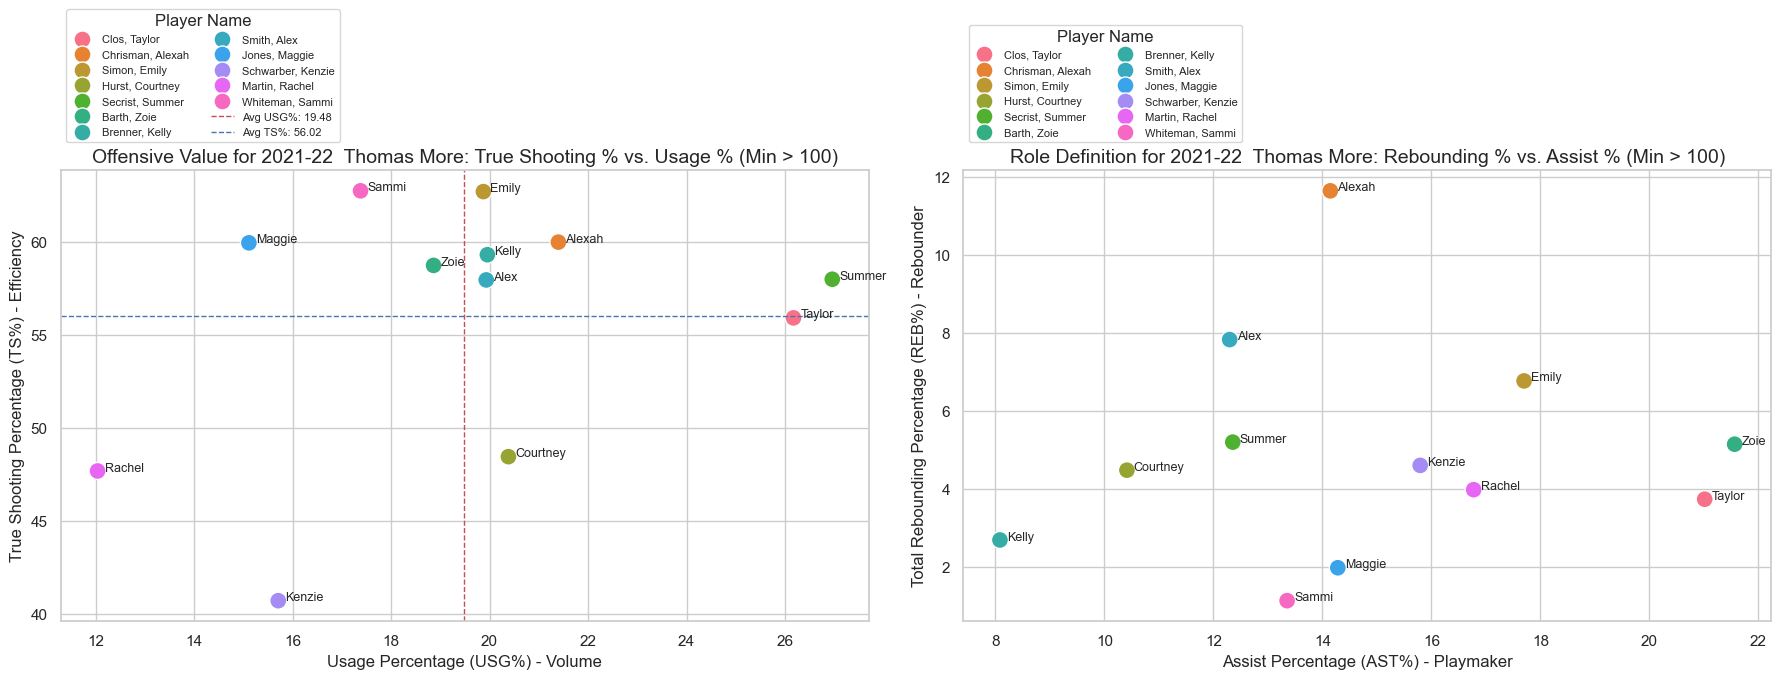


### Player Performance Summary for 2022-23 CLARKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
41,"Haase, Taylor",607,37.035,53.225,31.415,11.049,6.846,4.486
38,"Ubl, Tina",919,31.948,56.017,24.514,14.764,6.279,2.863
39,"Kelchen, Emma",869,31.162,58.387,23.329,10.913,8.394,4.090
40,"McDermottm, Nicole",1003,30.867,54.473,20.127,19.074,10.471,3.359
43,"Merschman, Mya",680,23.412,56.221,20.349,11.172,3.736,2.783
44,"Culbertson, Skylar",1047,22.388,50.860,13.815,28.720,9.629,4.585
45,"Lindauer, Madison",267,19.925,57.464,15.115,8.588,1.141,1.729
42,"Michels, Giana",911,19.100,53.315,17.813,14.518,3.482,2.989
46,"Peterson, Izzie",618,11.521,34.788,12.657,15.708,2.380,3.211


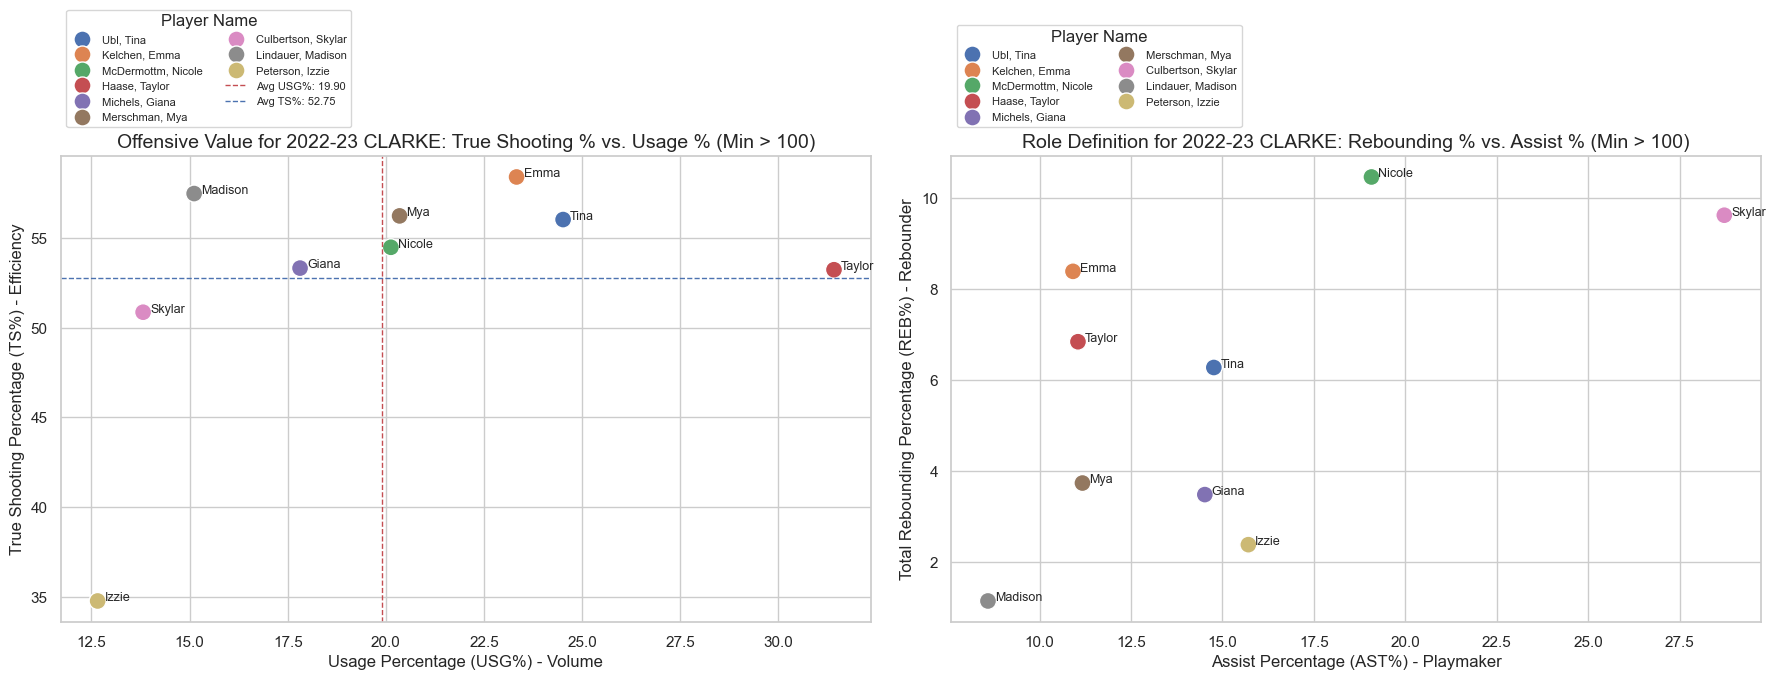


### Player Performance Summary for 2023-24 Dordt (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
56,"Schoonhoven, Gracie",483,45.383,69.487,29.451,25.119,4.614,5.100
53,"Sievers, Macy",990,39.152,60.222,22.146,43.000,9.805,4.569
54,"Gustafson, Karly",839,36.424,61.968,24.242,16.949,10.596,4.430
57,"Schoonhoven, Janie",903,34.197,67.182,19.221,9.347,12.684,3.571
63,"Drent, Taylor",160,31.750,46.400,22.425,9.134,2.148,2.519
61,"Kuperus, Eliana",426,25.258,47.454,16.585,9.061,5.427,2.628
62,"Harazin, Olivia",160,25.000,58.725,20.041,8.037,1.237,3.359
55,"Beckman, Bailey",942,22.930,44.053,26.792,5.993,3.023,2.187
59,"Heimensen, Hayden",421,22.518,51.633,15.628,16.011,3.136,2.340
69,"Smith, Brooke",106,18.868,28.694,16.004,15.822,1.459,4.225


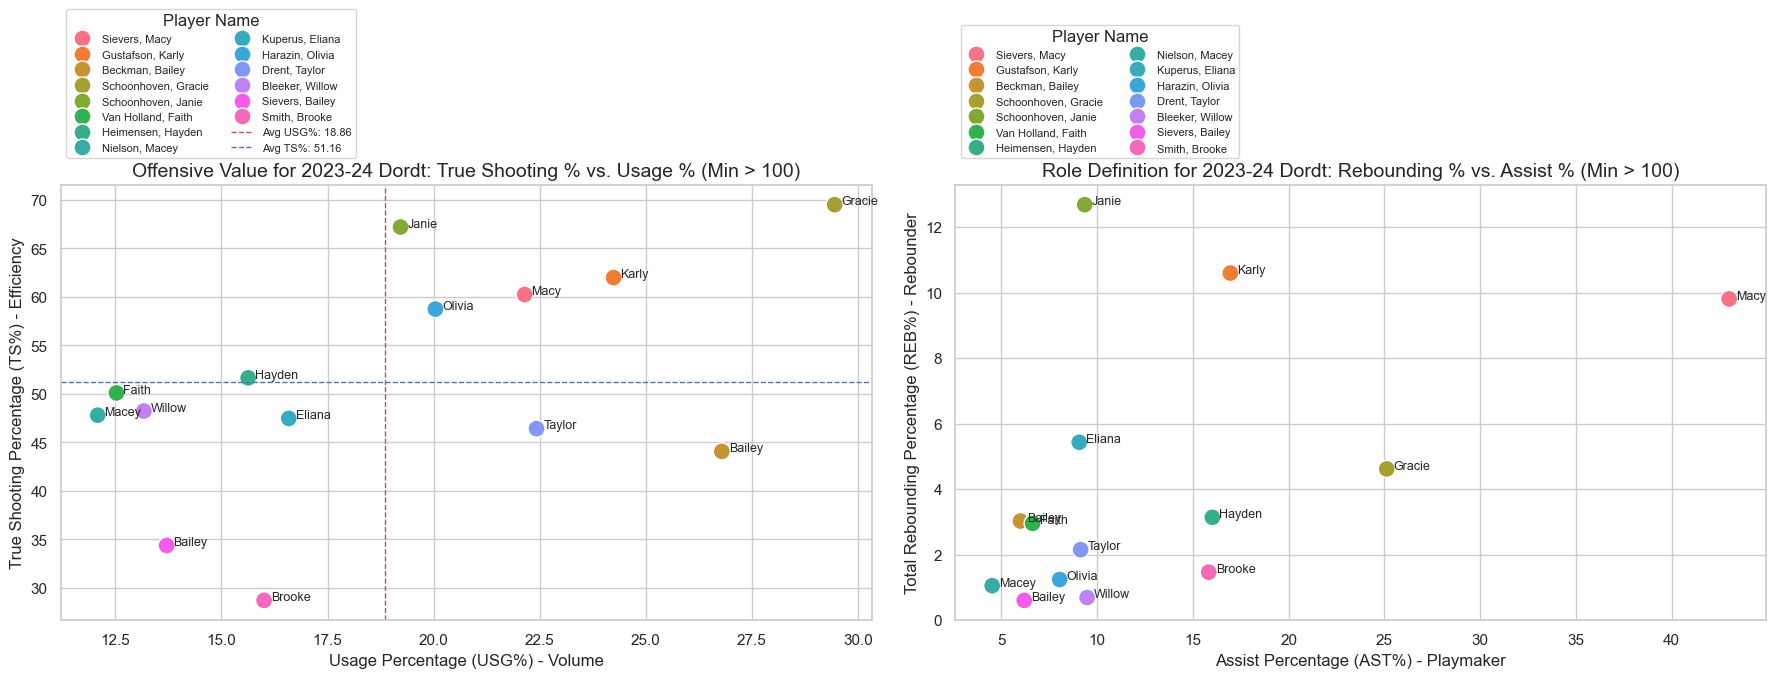


### Player Performance Summary for 2024-25 Dordt (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
71,"Van Donge, Janie",1044,40.153,63.891,23.968,11.673,15.105,3.168
72,"Sievers, Macy",1191,38.421,57.649,24.279,41.386,11.401,4.976
73,"Schoonhoven, Gracie",563,34.458,54.880,27.652,24.628,3.587,4.978
77,"Hoogendoorn, Desta",629,28.426,51.662,20.824,7.397,6.854,3.506
78,"Charleston, Stella",149,26.577,54.645,24.727,7.075,0.736,2.158
85,"Goodwin, McKenzie",101,25.743,44.643,18.467,7.486,1.481,3.184
79,"Drent, Taylor",206,22.136,39.507,17.903,8.173,2.519,3.791
74,"Harazin, Olivia",937,21.515,59.867,21.241,13.733,3.416,4.903
76,"Lems, Ellie",820,21.073,61.140,13.934,4.842,5.516,2.297
80,"Lingemann , Ava",137,18.978,45.685,16.230,18.318,0.797,3.018


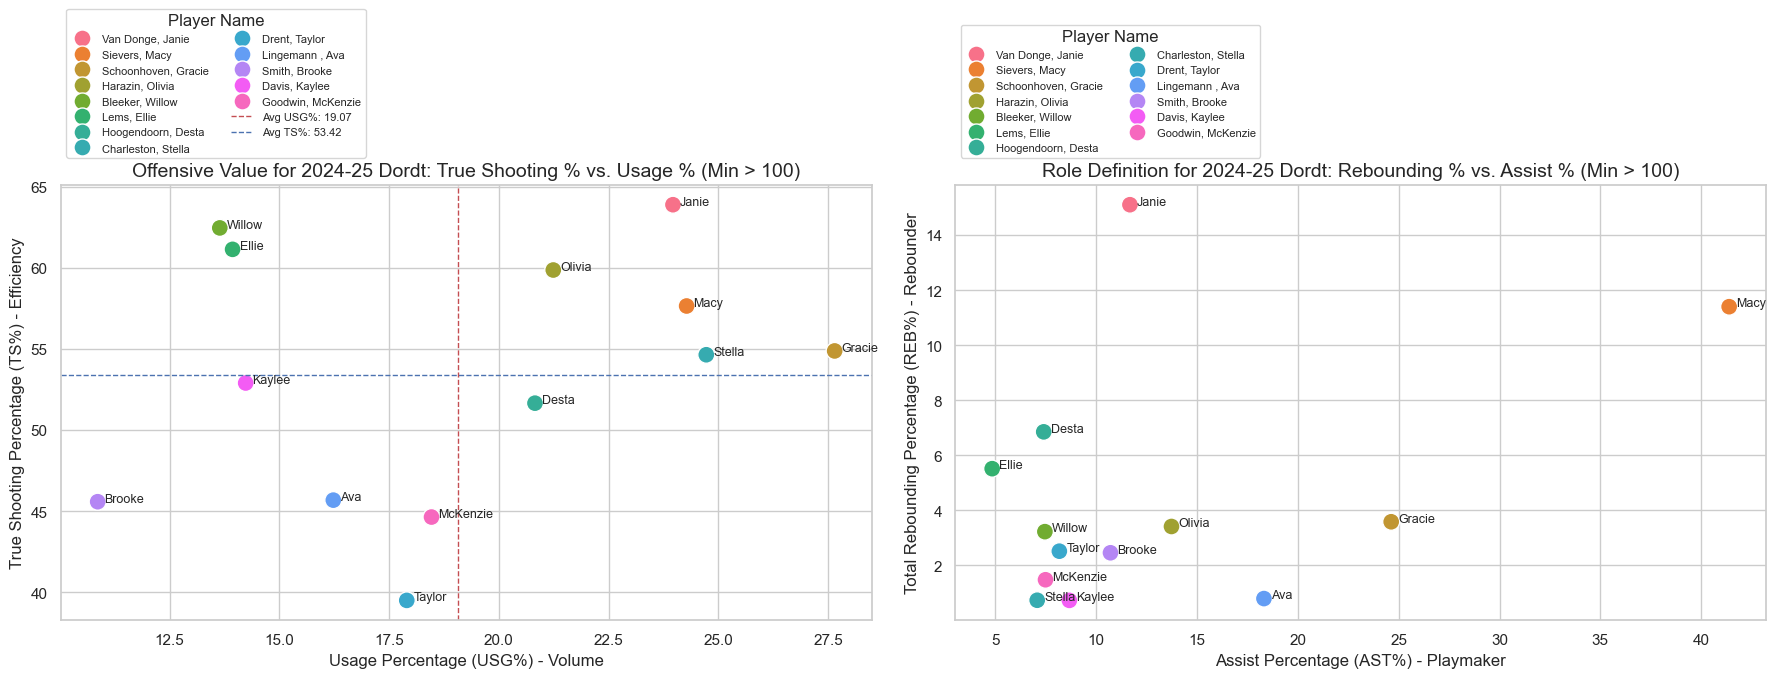


### Player Performance Summary for 2018-19 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
89,"Burbridge, Brianna",742,35.202,65.017,21.120,7.144,8.591,3.079
90,"Baker, Emily",887,27.644,53.103,17.461,17.748,7.404,2.524
88,"Englert, Mary",838,26.014,50.504,25.788,17.239,4.394,4.144
92,"Greatrex, Mia",498,25.703,53.130,21.839,11.298,3.821,4.312
94,"Odia, Theodora",542,20.886,46.396,21.974,9.388,3.438,4.805
91,"Mullins, Kayla",713,20.309,50.766,20.569,9.757,3.389,3.845
96,"Latham, Elisabeth",379,19.314,54.158,10.396,14.405,2.964,3.496
93,"Reed, Alexis",577,16.915,43.299,23.983,10.291,1.475,5.147
95,"Feltner, Sierra",717,15.732,46.939,14.689,16.310,4.452,4.779
98,"Estrada, Yurleis",120,15.667,41.209,22.859,6.004,0.897,7.615


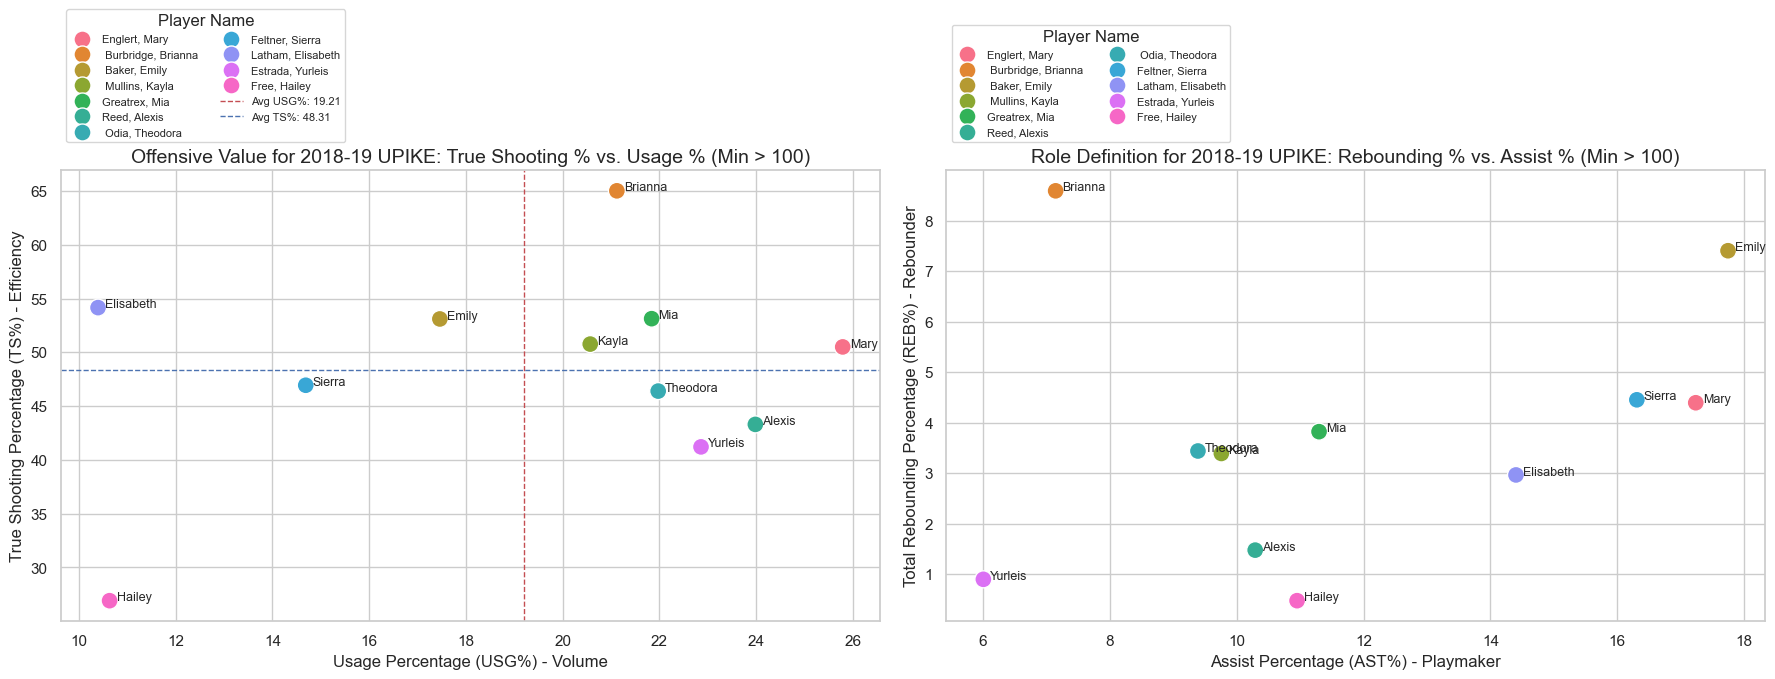


### Player Performance Summary for 2020-21 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
104,"Burbridge, Brianna",619,40.711,64.439,20.708,12.139,12.563,1.484
108,"Stamper, Morgan",566,24.664,40.513,18.769,11.617,9.060,3.651
105,"Englert, Mary",497,24.628,51.257,28.356,11.406,4.090,6.005
106,"Reed, Alexis",591,22.403,54.649,25.083,10.732,2.088,4.895
107,"Feltner, Sierra",735,21.279,49.529,19.072,18.787,5.982,3.936
109,"Frazier, Bailey",275,20.073,40.297,24.304,4.623,2.111,3.172
110,"Free, Hailey",353,16.997,52.339,14.413,14.040,2.280,2.732
113,"Hollier, Zaria",274,16.788,43.486,13.581,4.328,4.027,4.525
112,"Parker, Julia",274,13.577,46.272,13.179,5.040,0.877,0.503
115,"Aouinet, Fatma",149,13.154,38.897,13.646,9.849,1.583,4.931


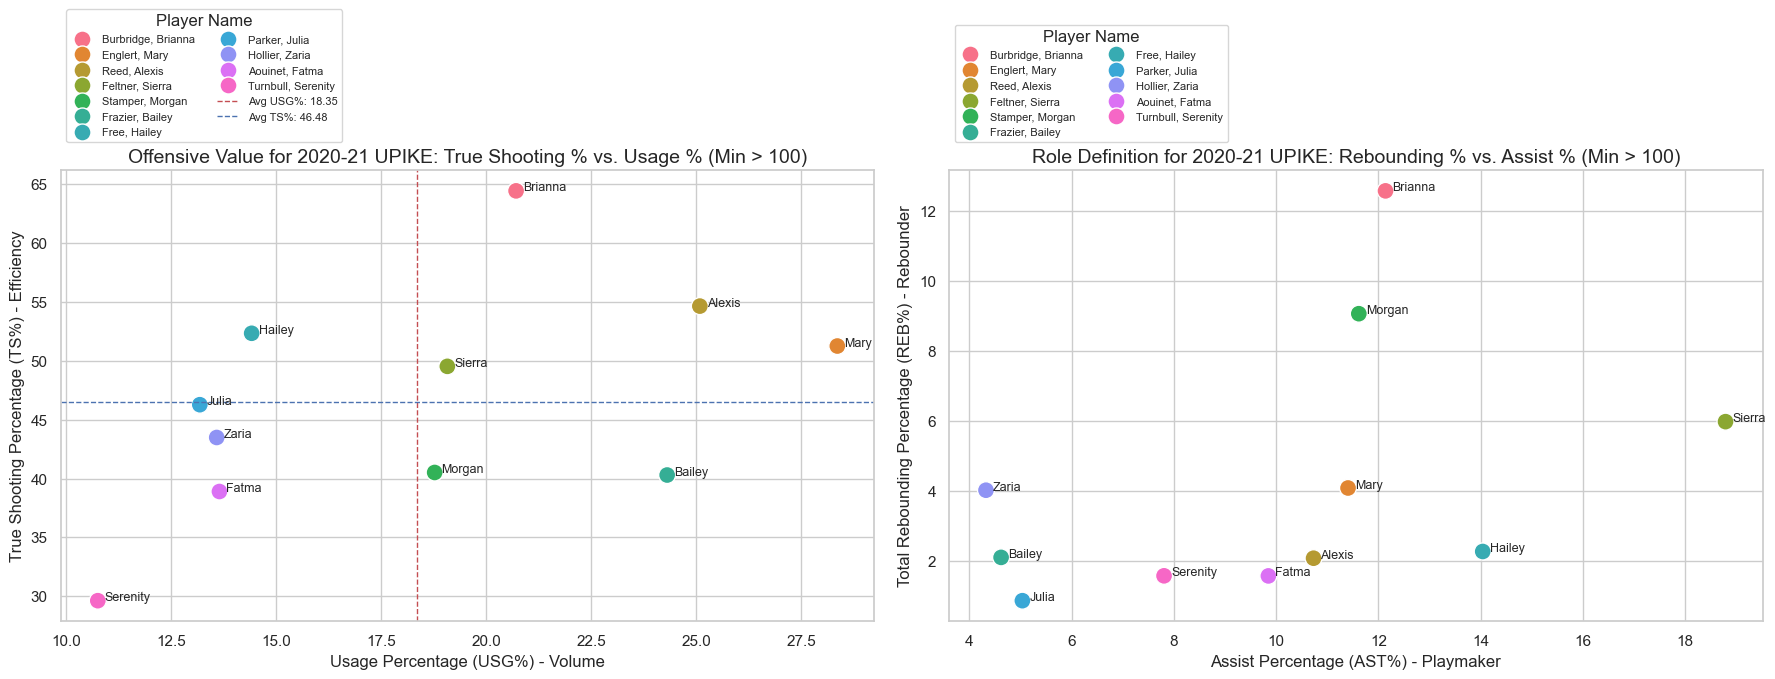


### Player Performance Summary for 2021-22 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
120,"Stamper, Morgan",1052,33.156,52.701,21.286,10.341,15.809,2.769
124,"McNulty, LeeAnna",543,29.540,57.447,20.182,4.133,6.614,1.731
119,"Englert, Mary",1052,28.973,45.262,27.379,18.755,10.583,3.796
122,"Frazier, Bailey",935,23.358,55.091,16.951,7.038,7.783,1.809
121,"Feltner, Sierra",987,21.114,47.882,19.881,16.077,6.393,3.427
123,"Reed, Alexis",703,18.890,49.782,21.133,8.404,2.385,2.740
125,"Free, Hailey",439,16.674,44.691,14.971,15.874,2.535,2.997
128,"Adkins, Abby",125,12.800,42.614,15.847,9.326,0.992,5.262
126,"Sideri, Georgia",544,12.353,49.711,13.708,9.187,2.033,2.937


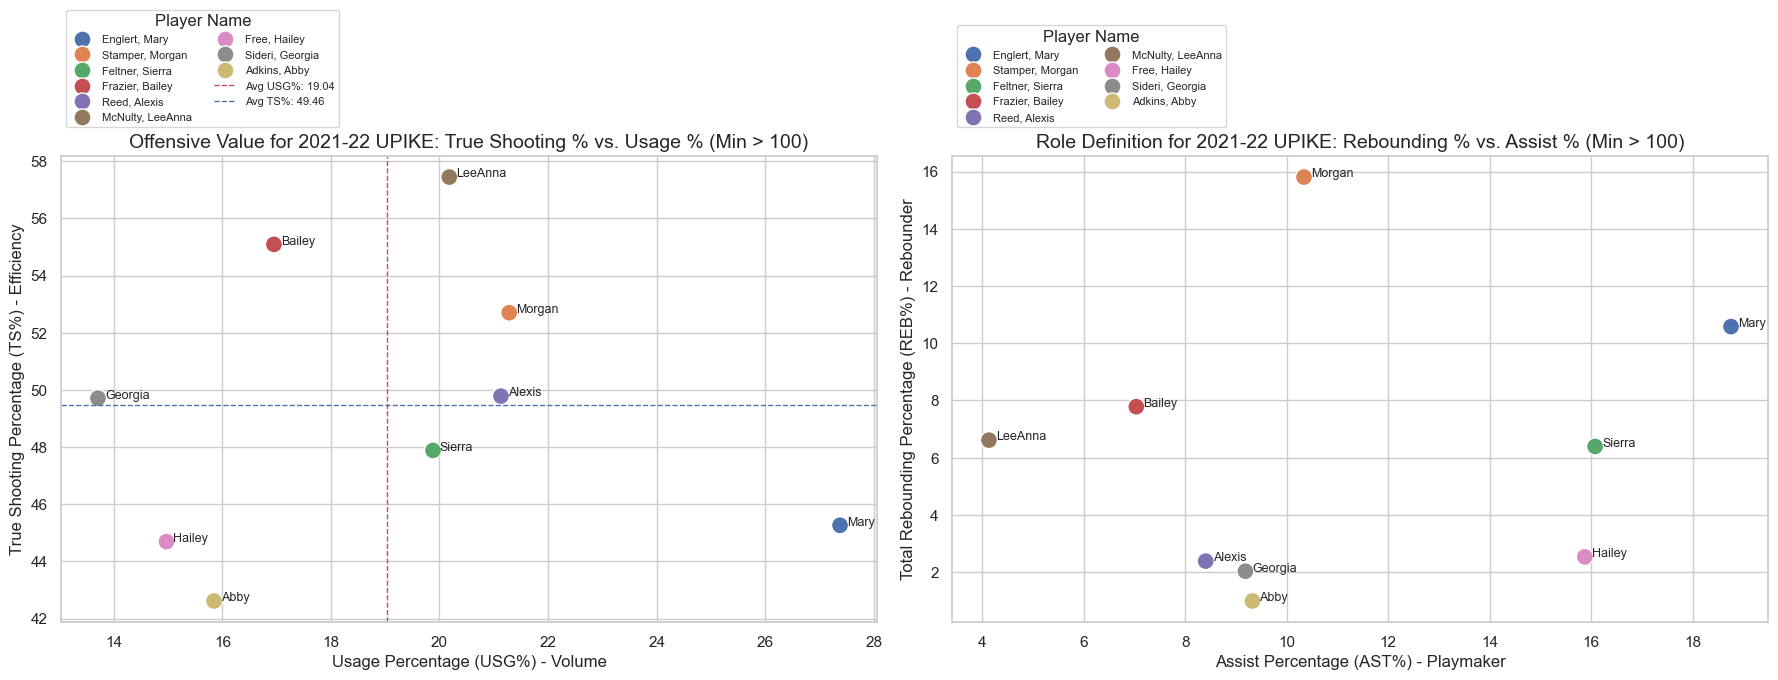


### Player Performance Summary for 2022-23 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
136,"Stamper, Morgan",751,29.880,53.580,19.172,7.693,12.553,2.257
138,"Roberts, Hannah",137,29.489,50.187,29.015,9.563,1.347,1.820
133,"Englert, Mary",859,29.243,45.126,30.593,21.016,9.301,3.773
135,"Frazier, Bailey",925,24.605,57.240,16.691,9.092,9.031,1.294
137,"Feltner, Sierra",965,24.041,48.083,20.115,23.026,8.596,3.565
134,"Stone, Allie",933,21.951,62.825,19.361,8.833,3.697,1.710
142,"Robbins, Sheridan",138,20.000,42.863,21.376,2.653,1.790,3.252
140,"Collopy, Katie",376,17.553,44.995,17.993,6.123,3.463,2.520
139,"Free, Hailey",614,16.091,41.099,14.215,19.480,4.300,3.248


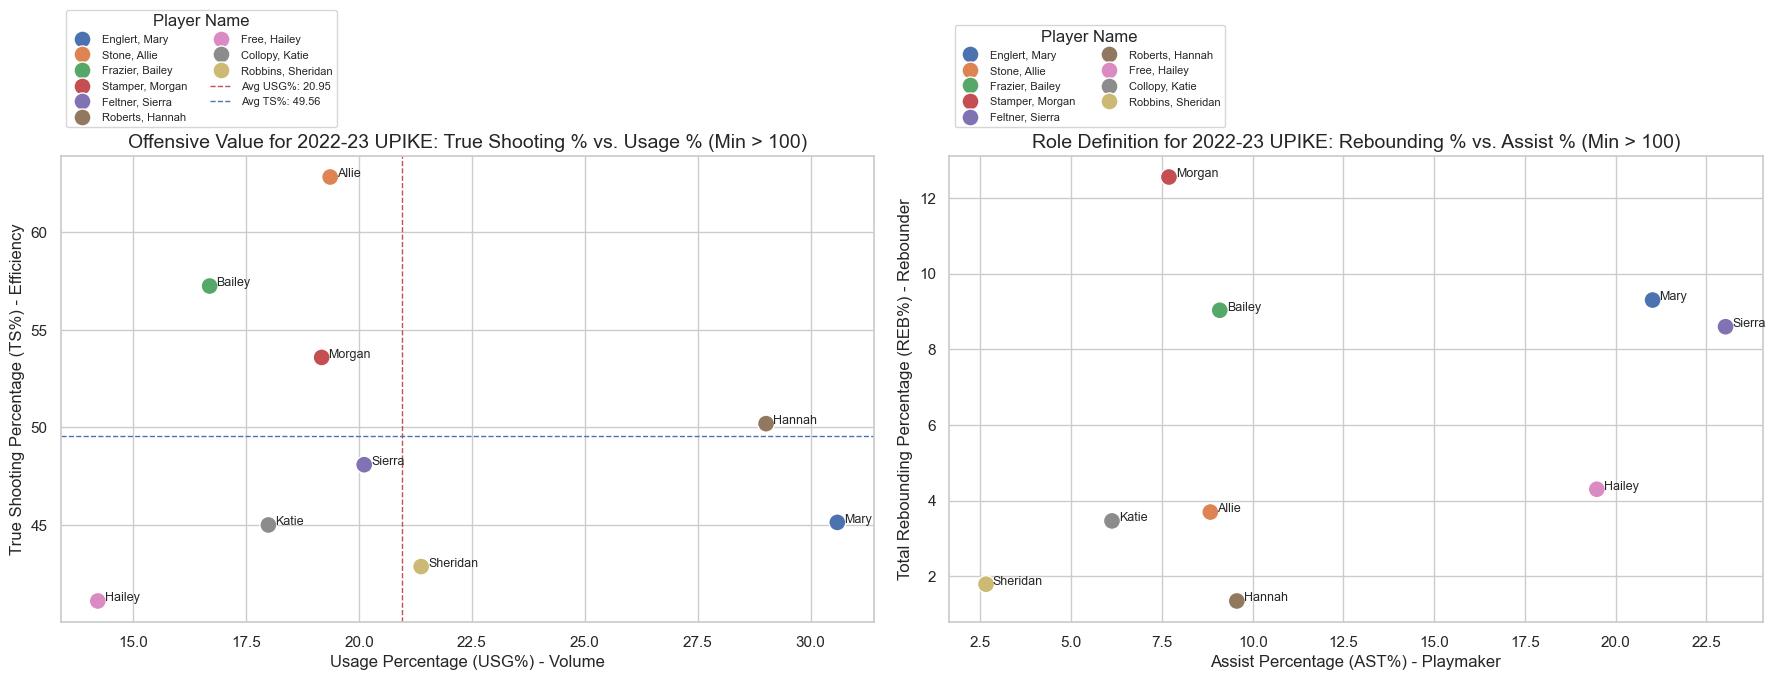


### Player Performance Summary for 2023-24 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
149,"Stamper, Morgan",940,37.149,55.822,19.286,13.918,17.597,2.400
151,"Bush, Rachel",664,32.048,59.071,19.479,10.181,7.831,1.982
148,"Stone, Allie",1053,30.731,63.781,25.718,17.645,3.963,2.902
150,"Frazier, Bailey",922,30.022,52.136,20.026,13.643,8.386,1.886
157,"Frazier, Brooklyn",103,27.573,57.398,21.084,22.240,0.778,3.195
159,"Mejia-Andrade, Jaidy",274,27.153,37.721,16.668,5.211,4.227,1.887
155,"Birchfield, Bailey",469,23.028,49.813,21.817,15.131,1.816,3.608
156,"Collopy, Katie",352,22.841,52.947,18.508,14.295,3.690,4.006
158,"Robbins, Sheridan",121,21.818,57.956,17.077,11.167,1.014,2.331
154,"Parker, Julia",544,20.441,62.938,14.392,11.922,2.042,1.555


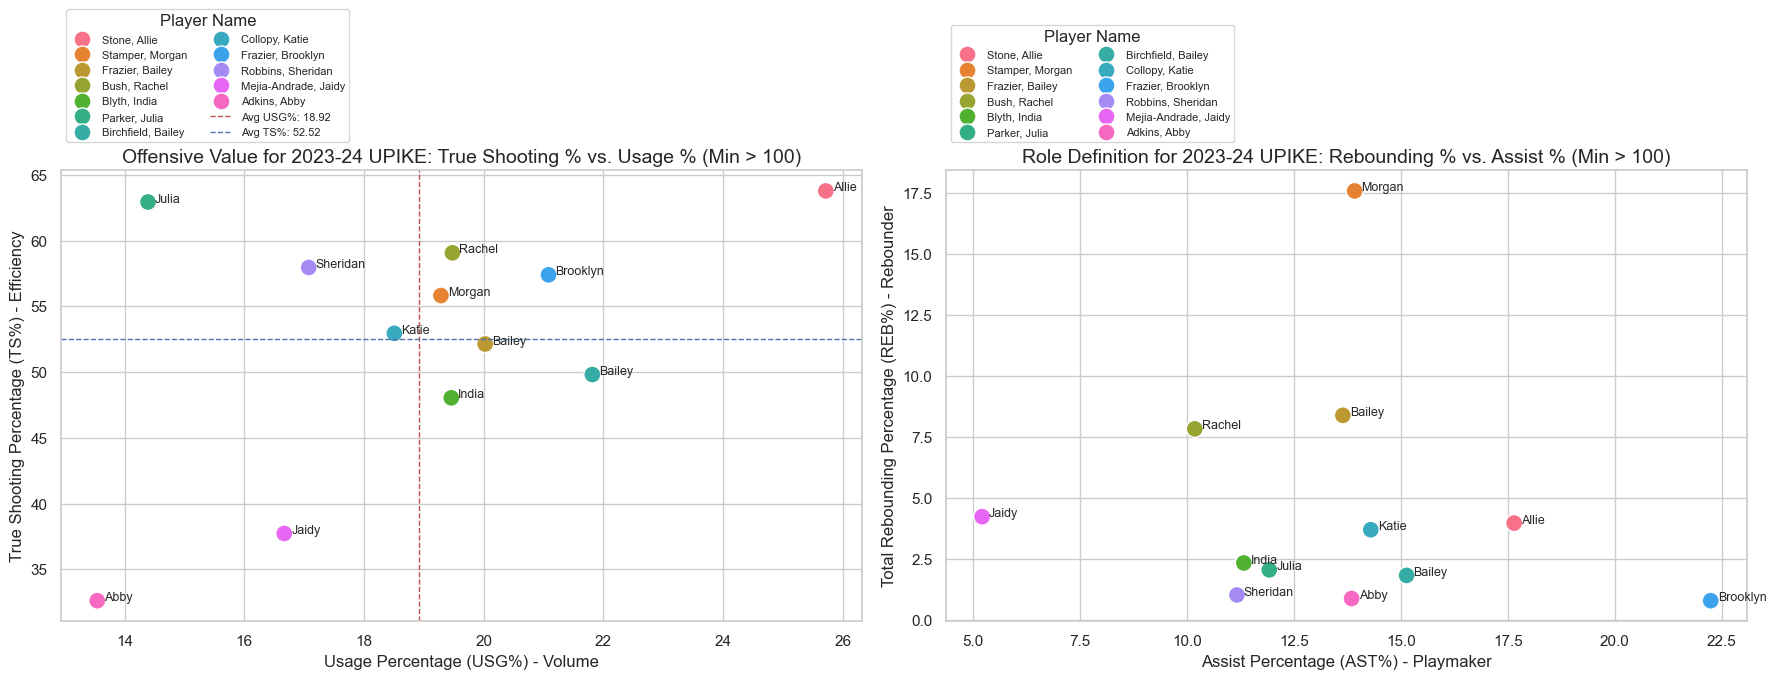


### Player Performance Summary for 2024-25 UPIKE (Top 10 by PEI/40)

,Player_Name,MIN,PEI_40,TS%,USG%,AST%,REB%,TOV%
164,"Bush, Rachel",841,33.960,60.131,23.444,11.976,10.638,3.215
163,"Stone, Allie",1012,31.660,63.417,26.645,22.014,4.137,2.319
167,"Moore, Alexis",373,25.094,53.957,22.159,16.368,2.848,3.146
166,"Warren, Jaaliyah",555,22.486,58.854,22.007,12.066,3.233,4.045
169,"Mejia-Andrade, Jaidy",733,21.446,38.788,14.199,13.336,8.004,2.715
170,"Ayler, Paige",237,21.266,35.311,13.700,12.089,3.059,1.507
168,"Collopy, Katie",713,19.299,43.214,14.254,15.869,7.621,3.077
171,"Smith, Alana",213,19.155,38.071,16.805,6.464,2.562,3.593
165,"Blyth, India",863,16.871,54.194,18.710,13.579,1.849,2.838


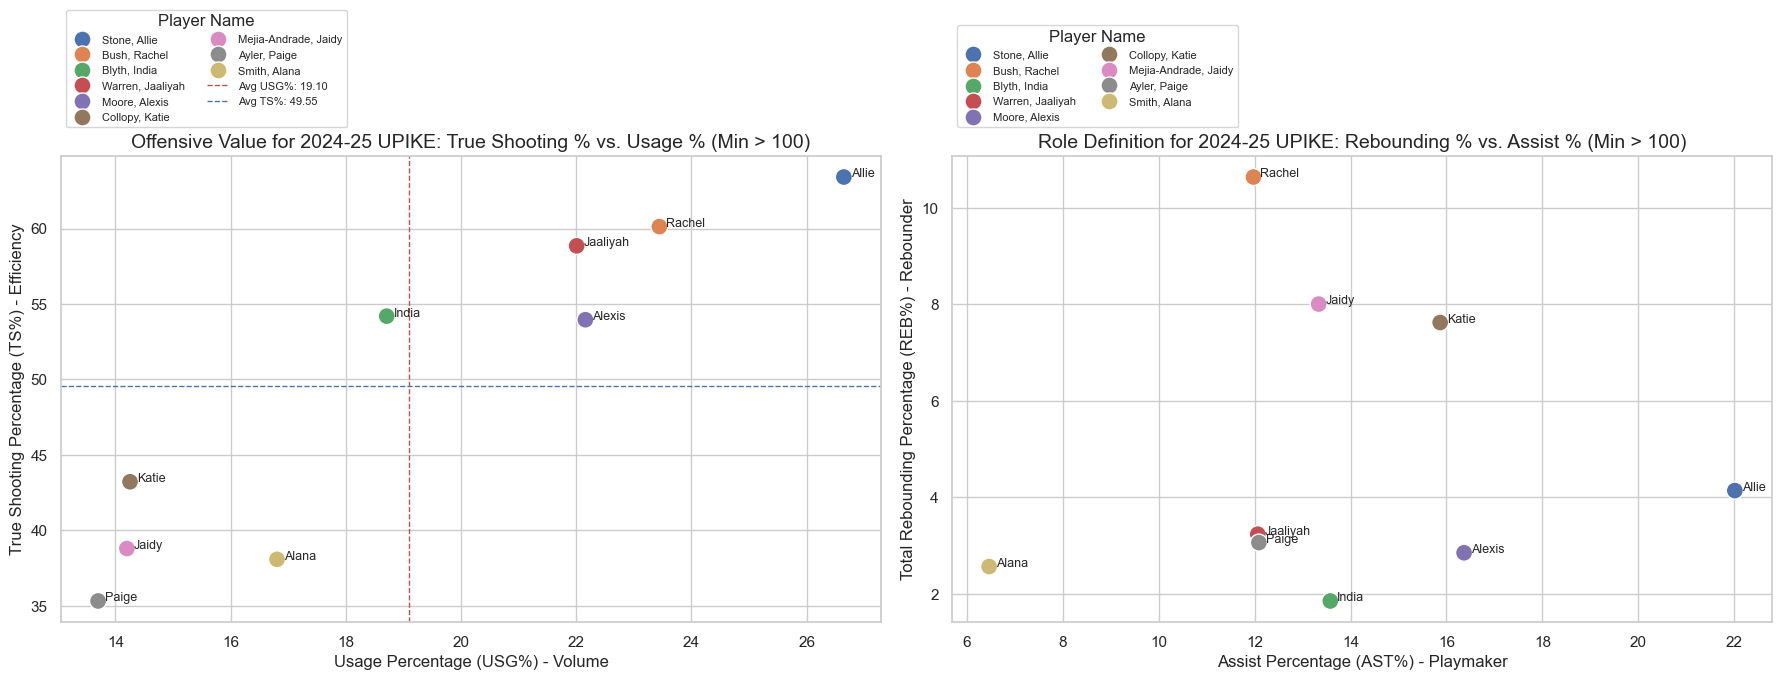

In [40]:
#====================================================FIRST DELIVERABLE PART 2=============================


# Generate player summary tables and visualizations for each team
print(f"\n--- GENERATING VISUALIZATIONS FOR ALL {len(ANALYSIS_SHEET_NAMES)} TEAMS ---")


#Columns to include in summary tables, using standardized names (renamed in line 49)
SUMMARY_TABLE_COLS = REQUIRED_COLS_CHECK

#Minimum minutes threshold to reduce statistical noise from players with very limited play time 
MIN_MINUTES_THRESHOLD = 100

#Loop through each team for visualization
for viz_sheet_name in ANALYSIS_SHEET_NAMES:
    
    # Filter master data for the current team
    viz_df = master_player_df[master_player_df['Team_Sheet'] == viz_sheet_name].copy()


    #Just to be safe: Skip if no data is found for the team
    if viz_df.empty:
        print(f"Warning: No data found for '{viz_sheet_name}'. Skipping charts.")
        continue

    
    # Filtering out players that played less than the threshold and also creating a copy
    viz_df_filtered = viz_df[viz_df['MIN'] >= MIN_MINUTES_THRESHOLD].copy()

    
    
    # --- PLAYER SUMMARY TABLE (Top 10 by PEI/40) ---
    display(Markdown(f"\n### Player Performance Summary for {viz_sheet_name} (Top 10 by PEI/40)"))
    
    #Select top 10 players by PEI/40
    top_10_players = viz_df_filtered[SUMMARY_TABLE_COLS].sort_values(by='PEI_40', ascending=False).head(10)
    
    #Custumize format for decimals
    format_dict = {
        'MIN': '{:.0f}',  
        'PEI_40': '{:.3f}',
        'TS%': '{:.3f}',
        'USG%': '{:.3f}',
        'AST%': '{:.3f}',
        'REB%': '{:.3f}',
        'TOV%': '{:.3f}',
    }

    #Display the DataFrame object after applying the style formatting
    display(top_10_players.style.format(format_dict))

    

    # --- COMBINED VISUALIZATION: OFFENSE AND ROLES ---
    
    # Create a figure with two subplots (1 row, 2 columns) for side-by-side comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))

    # --- Plot 1: OFFENSIVE EFFICIENCY VS USAGE (ax1) ---
    # Legend is now set to True to display it
    sns.scatterplot(x='USG%', y='TS%', data=viz_df_filtered, hue='Player_Name', s=150, ax=ax1, legend=True)
    
    #Add player labels to the points (using only the last name for cleanliness)
    for i, row in viz_df_filtered.iterrows():
        # This line is safe because we forced 'Player_Name' to string in Section 2
        last_name = row['Player_Name'].split(' ')[-1]
        ax1.annotate(last_name, (row['USG%'], row['TS%']), 
                     textcoords="offset points", xytext=(5, 0), ha='left', fontsize=9)
    
    # Calculate and plot team averages (for context)
    avg_usg = viz_df_filtered['USG%'].mean()
    avg_ts = viz_df_filtered['TS%'].mean()
    
    ax1.set_title(f'Offensive Value for {viz_sheet_name}: True Shooting % vs. Usage % (Min > {MIN_MINUTES_THRESHOLD})', fontsize=14)
    ax1.set_xlabel('Usage Percentage (USG%) - Volume', fontsize=12)
    ax1.set_ylabel('True Shooting Percentage (TS%) - Efficiency', fontsize=12)
    ax1.axvline(avg_usg, color='r', linestyle='--', linewidth=1, label=f'Avg USG%: {avg_usg:.2f}')
    ax1.axhline(avg_ts, color='b', linestyle='--', linewidth=1, label=f'Avg TS%: {avg_ts:.2f}')
    
    # Move the legend outside to the right for Plot 1 to avoid overlap with data points
    ax1.legend(loc='lower left', bbox_to_anchor=(0.0, 1.05), ncol=2, fontsize=8, title="Player Name")


    # --- Plot 2: REBOUNDING VS. PLAYMAKING (ax2) ---
    # Legend is now set to True to display it
    sns.scatterplot(x='AST%', y='REB%', data=viz_df_filtered, hue='Player_Name', s=150, ax=ax2, legend=True)
    
    # Add player labels to the points
    for i, row in viz_df_filtered.iterrows():
        last_name = row['Player_Name'].split(' ')[-1]
        ax2.annotate(last_name, (row['AST%'], row['REB%']), 
                     textcoords="offset points", xytext=(5, 0), ha='left', fontsize=9)
                     
    ax2.set_title(f'Role Definition for {viz_sheet_name}: Rebounding % vs. Assist % (Min > {MIN_MINUTES_THRESHOLD})', fontsize=14)
    ax2.set_xlabel('Assist Percentage (AST%) - Playmaker', fontsize=12)
    ax2.set_ylabel('Total Rebounding Percentage (REB%) - Rebounder', fontsize=12)
    
    # Move the legend outside to the right for Plot 2 to avoid overlap with data points
    ax2.legend(loc='lower left', bbox_to_anchor=(0.0, 1.05), ncol=2, fontsize=8, title="Player Name")
    
    # Adjust layout to prevent labels from overlapping and display the combined figure
    plt.tight_layout()
    plt.show()


--- SECTION 4: INTER-TEAM TOP PLAYER COMPARISON ---
Identifying the top player from each team (Min > 100 minutes) by PEI/40 and sorting chronologically (Opponent then UPIKE).


/var/folders/16/slv7nw2d3sgcrpm437z5my8h0000gn/T/ipykernel_19636/4016378763.py:65: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='PEI_40', y='Team', data=top_players_comparison_df, palette=custom_colors)


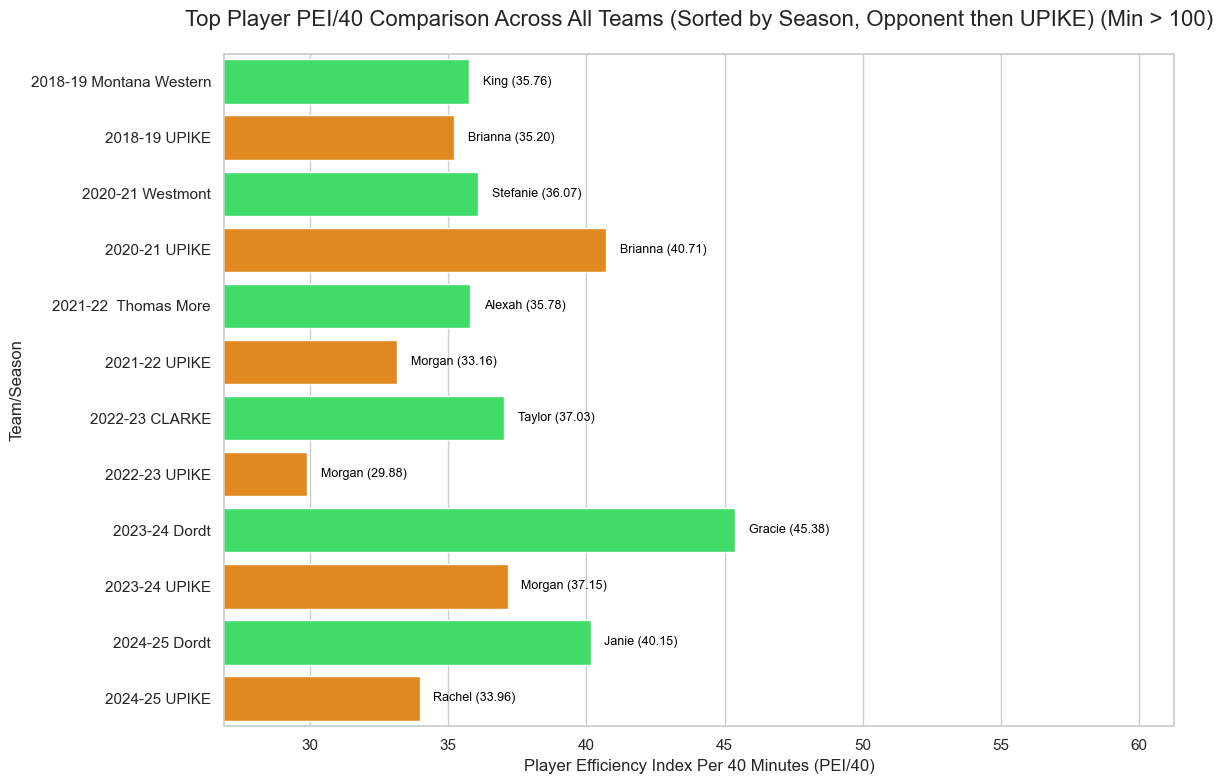

In [41]:
#====================================================FIRST DELIVERABLE PART 3=============================



print("\n--- SECTION 4: INTER-TEAM TOP PLAYER COMPARISON ---")
print(f"Identifying the top player from each team (Min > {MIN_MINUTES_THRESHOLD} minutes) by PEI/40 and sorting chronologically (Opponent then UPIKE).")

#Prepare data for comparison– Filter out players below the min minutes threshold (again, removes statistical noise)
top_players_list = []
qualified_players_df = master_player_df[master_player_df['MIN'] >= MIN_MINUTES_THRESHOLD].copy()

#Iterate through each team and find the best player
for team_sheet in ANALYSIS_SHEET_NAMES:
    team_data = qualified_players_df[qualified_players_df['Team_Sheet'] == team_sheet]
    
    if not team_data.empty:
        # Sort by PEI_40 and get the top row
        top_player_row = team_data.sort_values(by='PEI_40', ascending=False).iloc[0]
        
        # Store the necessary info
        top_players_list.append({
            'Team': top_player_row['Team_Sheet'],
            'Player_Name': top_player_row['Player_Name'],
            'PEI_40': top_player_row['PEI_40']
        })

#Create a DataFrame for the top players
top_players_comparison_df = pd.DataFrame(top_players_list)


#--- Extract Year and Flag for Custom Sort ---
#Extract starting year from team name (first 4 digits)
top_players_comparison_df['Start_Year'] = top_players_comparison_df['Team'].apply(
    lambda x: int(re.search(r'^\d{4}', x).group(0)) if re.search(r'^\d{4}', x) else 9999
)

#Flag UPIKE teams for sorting and coloring
top_players_comparison_df['Is_UPIKE_Flag'] = top_players_comparison_df['Team'].apply(
    lambda x: 1 if 'UPIKE' in x.upper() else 0
)

# Sort the DataFrame first by year, and second by the custom flag (Opponent before UPIKE)
top_players_comparison_df = top_players_comparison_df.sort_values(
    by=['Start_Year', 'Is_UPIKE_Flag'], 
    ascending=[True, True]
).reset_index(drop=True)

# --- Prepare colors for the bar chart ---
UPIKE_COLOR = '#FF8C00'  # Orange
STANDARD_COLOR = '#27F55B' #Green

 
custom_colors = []
for team in top_players_comparison_df['Team']:
    # Check if 'UPIKE' is in the team name (case-insensitive)
    if 'UPIKE' in team.upper():
        custom_colors.append(UPIKE_COLOR)
    else:
        custom_colors.append(STANDARD_COLOR)


# --- Generate Bar Chart ---
plt.figure(figsize=(12, 8))
# Pass the custom_colors list to the 'palette' argument
ax = sns.barplot(x='PEI_40', y='Team', data=top_players_comparison_df, palette=custom_colors)

#Add Labels and Title
plt.title(f'Top Player PEI/40 Comparison Across All Teams (Sorted by Season, Opponent then UPIKE) (Min > {MIN_MINUTES_THRESHOLD})', fontsize=16, pad=20)
plt.xlabel('Player Efficiency Index Per 40 Minutes (PEI/40)', fontsize=12)
plt.ylabel('Team/Season', fontsize=12)

# Annotate Bars with Player Name and PEI/40 Value
for index, row in top_players_comparison_df.iterrows():
    # Use Player's last name for cleaner annotation
    player_label = f"{row['Player_Name'].split(' ')[-1]} ({row['PEI_40']:.2f})"
    
    # Choose annotation color based on the bar color for better contrast
    text_color = 'black' 
    
    ax.text(row['PEI_40'] + 0.5, # X position (slightly past the bar end)
            index,               # Y position (the center of the bar)
            player_label, 
            color=text_color, 
            ha="left", 
            va="center",
            fontsize=9)
    
#Adjust x-axis for annotation visibility and display chart
plt.xlim(top_players_comparison_df['PEI_40'].min() * 0.9, top_players_comparison_df['PEI_40'].max() * 1.35) # Adjust x-axis limits for annotations
plt.tight_layout()
plt.show()

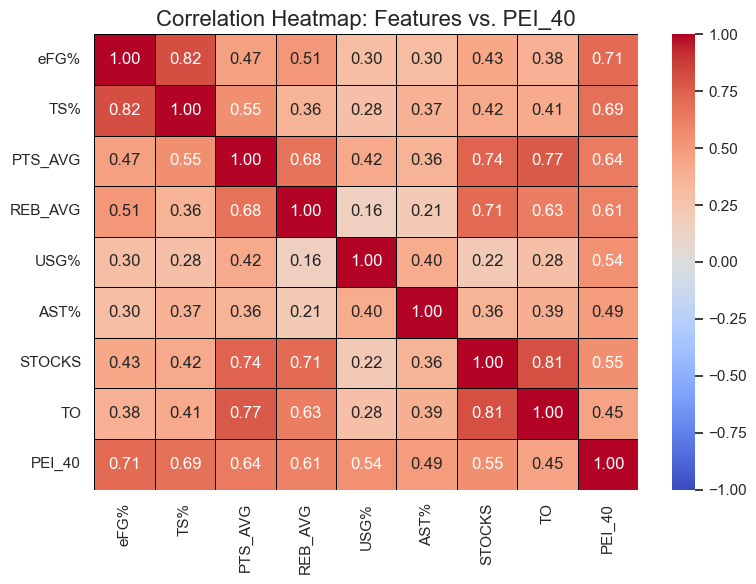

In [49]:
#====================================================2nd DELIVERABLE =============================

#This is to find which features are more correlated to PEI_40 

#Load cleaned master player data
df = pd.read_csv('master_player_analysis_FULL.csv')
#Drop irrelevant or duplicate columns
df.drop(columns=['Postions', 'Positions', 'Unnamed: 42'], inplace=True)
#Save cleaned version for future use
df.to_csv('master_player_analysis_FULL_clean.csv', index=False)
#Calculate correlation of all numeric features with PEI_40
corr = df.corr(numeric_only=True)[['PEI_40']].sort_values(by='PEI_40', ascending=False)

 
# ------------------------------------ HEATMAP OF SELECTED FEATURES ------------------------------------

#Feature to analyze vs PEI/40
FEATURE_X = [
    'eFG%',
    'TS%',
    'PTS_AVG',
    'REB_AVG',
    'USG%',
    'AST%',
    'STOCKS',
    'TO'
]

# Filter for only the columns we care about
cols_to_plot = FEATURE_X + ['PEI_40']
    
# Calculate correlation matrix
corr_matrix = df[cols_to_plot].corr()

#Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            vmin=-1, 
            vmax=1, 
            linewidths=0.5,
            linecolor='black')
    
plt.title('Correlation Heatmap: Features vs. PEI_40', fontsize=16)
plt.tight_layout()
plt.show()

#Load cleaned data again for further visualizations
df_viz = pd.read_csv('master_player_analysis_FULL_clean.csv')





In [43]:
# ==================================================== COUNT PLAYERS ABOVE PEI_40 MEAN ===================================================

#Load cleaned player data
df = pd.read_csv('master_player_analysis_FULL_clean.csv')

#Calculate the mean PEI_40
mean_pei = df['PEI_40'].mean()

#Count how many players are above the mean
count_above_mean = sum(df['PEI_40'] > mean_pei)

print(f"Number of players above the mean PEI/40: {count_above_mean}")


Number of players above the mean PEI/40: 83


In [54]:

#==================================================== 3RD DELIVERABLE: PEI_40 PREDICTIVE MODEL ===================================================


#----------------------------------------- CONFIGURATION -------------------------------------------

INPUT_PLAYER_DATA_FILE = 'master_player_analysis_FULL_clean.csv'
TARGET_Y = 'PEI_40'
FEATURE_X = [
    'eFG%',
    'TS%',
    'PTS_AVG',
    'REB_AVG',
    'USG%',
    'AST%',
    'STOCKS',
    'TO'
]
MIN_MINUTES_THRESHOLD = 100
RANDOM_SEED = 42
RIDGE_ALPHA = 1.353048 

#----------------------------------------- MODEL EXECUTION -------------------------------------------

print("--- PEI_40 Predictive Model (Using Pipeline Best Practice) ---")

try:
    #Load and Filter the data
    df = pd.read_csv(INPUT_PLAYER_DATA_FILE)
    df_filtered = df[df['MIN'] >= MIN_MINUTES_THRESHOLD].copy()
    
    #Keep only relevant features + target, drop missing rows
    required_cols = [TARGET_Y] + FEATURE_X
    df_filtered.dropna(subset=required_cols, inplace=True)
    
    X = df_filtered[FEATURE_X].copy()
    y = df_filtered[TARGET_Y].copy()
    
    # Handle NaN and Inf
    X.replace([np.inf, -np.inf], np.nan, inplace=True)
    X.fillna(X.mean(), inplace=True)
    
    N = len(df_filtered)
    print(f"Filtered to {N} qualified player-seasons (MIN >= {MIN_MINUTES_THRESHOLD}).")

    #Train/Test Split train = 80%, test = 20%
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_SEED
    )

    #Pipeline Construction
    pipeline = Pipeline([
        ('scaler', StandardScaler()),                      # Scale the data
        ('ridge', Ridge(alpha=RIDGE_ALPHA, random_state=RANDOM_SEED)) # Apply Ridge Regression
    ])

    #Train the pipeline using .fit
    pipeline.fit(X_train, y_train)
    print("\nPipeline successfully fitted on training data.")

    #Predict and Evaluate on Test Set
    y_pred = pipeline.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    print("\n" + "="*80)
    print("                      MODEL VALIDATION (RIDGE REGRESSION WITH PIPELINE)")
    print("="*80)
    print(f"Fixed Ridge Alpha: {RIDGE_ALPHA:.6f} ")
    print(f"R² Score (Test Data): {r2:.4f}")
    print(f"MSE (Test Data): {mse:.4f}")
    print("--------------------------------------------------------------------------------")
    
    # ---------------------- Extract the Required Parameters for Deployment/Simulator -----------------------
    
    #Fitted components
    fitted_scaler = pipeline.named_steps['scaler']
    fitted_model = pipeline.named_steps['ridge']

    #Feature importance (standardized coefficients)
    coefficients = pd.DataFrame({
        'Feature': FEATURE_X,
        # *** FIX APPLIED HERE: changed 'model.coef_' to 'fitted_model.coef_' ***
        'Scaled Coefficient': fitted_model.coef_ 
    })
    
    #Sort by absolute value to find most impactful features
    coefficients['Abs_Coefficient'] = coefficients['Scaled Coefficient'].abs()
    coefficients = coefficients.sort_values(by='Abs_Coefficient', ascending=False).drop(columns=['Abs_Coefficient'])
    
    print("\n" + "="*80)
    print("                      FEATURE IMPORTANCE (STANDARDIZED COEFFICIENTS)")
    print("="*80)
    print(coefficients.to_markdown(index=False, floatfmt=".6f"))
    print("--------------------------------------------------------------------------------")
    print("\nNOTE: The scaled coefficient shows the directional impact of each feature on PEI_40.")
    
    # --- REQUIRED SIMULATOR PARAMETERS ---
    print("\n\n--- REQUIRED SIMULATOR PARAMETERS (EXTRACTED FROM PIPELINE) ---")
    print(f"RIDGE_INTERCEPT = {fitted_model.intercept_}")
    print(f"RIDGE_COEFFICIENTS = {fitted_model.coef_}")
    print(f"SCALER_MEAN = {fitted_scaler.mean_}")
    print(f"SCALER_STD = {fitted_scaler.scale_}")
    print("-------------------------------------------------------------\n")

except FileNotFoundError:
    print(f"\n🛑 ERROR: The file '{INPUT_PLAYER_DATA_FILE}' was not found.")
except Exception as e:
    print(f"\n🛑 CRITICAL ERROR during pipeline modeling: {e}")

--- PEI_40 Predictive Model (Using Pipeline Best Practice) ---
Filtered to 127 qualified player-seasons (MIN >= 100).

Pipeline successfully fitted on training data.

                      MODEL VALIDATION (RIDGE REGRESSION WITH PIPELINE)
Fixed Ridge Alpha: 1.353048 
R² Score (Test Data): 0.9329
MSE (Test Data): 3.9922
--------------------------------------------------------------------------------

                      FEATURE IMPORTANCE (STANDARDIZED COEFFICIENTS)
| Feature   |   Scaled Coefficient |
|:----------|---------------------:|
| USG%      |             4.389622 |
| REB_AVG   |             3.092672 |
| TO        |            -2.757700 |
| STOCKS    |             1.870181 |
| AST%      |             1.405635 |
| TS%       |             1.269945 |
| eFG%      |             1.227883 |
| PTS_AVG   |            -0.906184 |
--------------------------------------------------------------------------------

NOTE: The scaled coefficient shows the directional impact of each feature on

In [45]:

# ==================================================== OBJECT-ORIENTED MODEL EVALUATION =========================================================

#This encapsulates the evaluation logic for clarity and reuse in other seasons 

 
class ModelEvaluator: 
    
    """encapsulates model evaluation metrics. Currently supports MSE """
    def __init__(self, actual, predicted):
        self.actual = actual
        self.predicted = predicted

    """ Calculates MSE """
    def calculate_mse(self):
        return mean_squared_error(self.actual, self.predicted) 


 
#Create the object of the class ModelEvaluator
evaluator = ModelEvaluator(y_test, y_pred)

# Calculate MSE using the object-oriented approach
#Calculating it using OOME (Object-Oriented Model Evaluation)
mse_oop = evaluator.calculate_mse()

print(f"MSE calculated via ModelEvaluator class: {mse_oop:.4f}")

# Verification against previous calculation, to see if it is correct
if mse_oop == mse:
    print( 'Object-Oriented Model Evaluation CORRECTLY implemented :)')



MSE calculated via ModelEvaluator class: 3.9922
Object-Oriented Model Evaluation CORRECTLY implemented :)


--- Starting Model Visualization ---


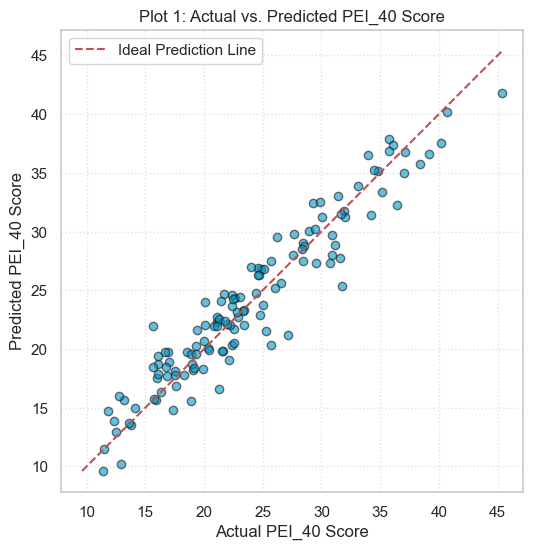

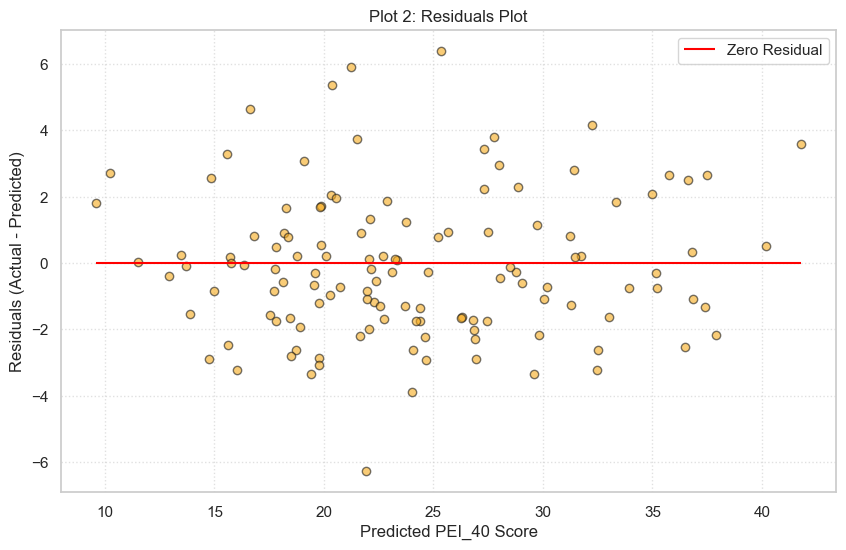

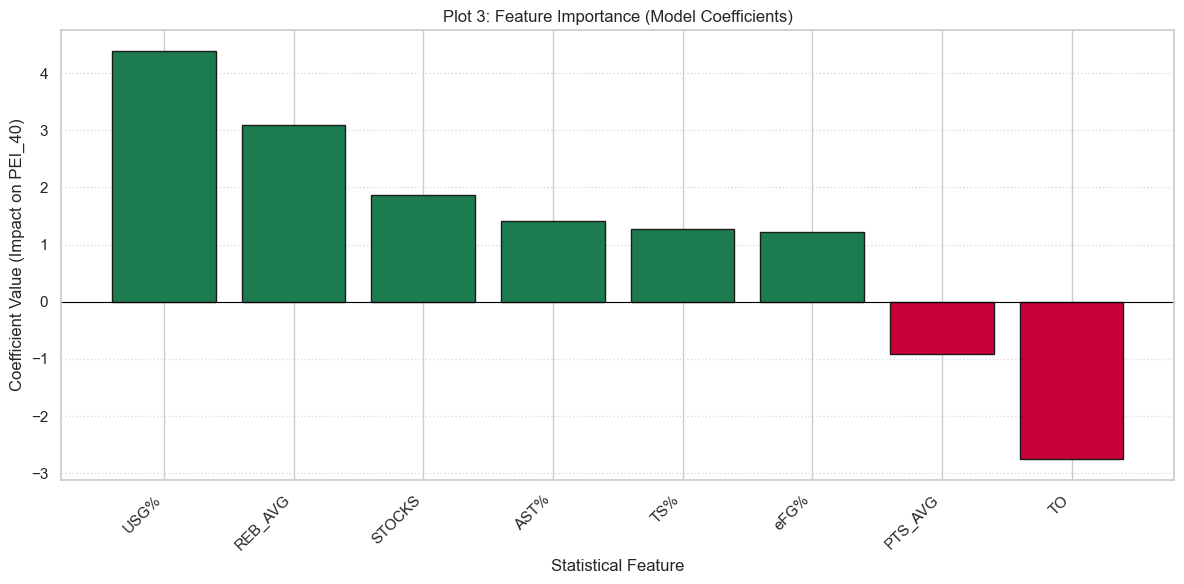

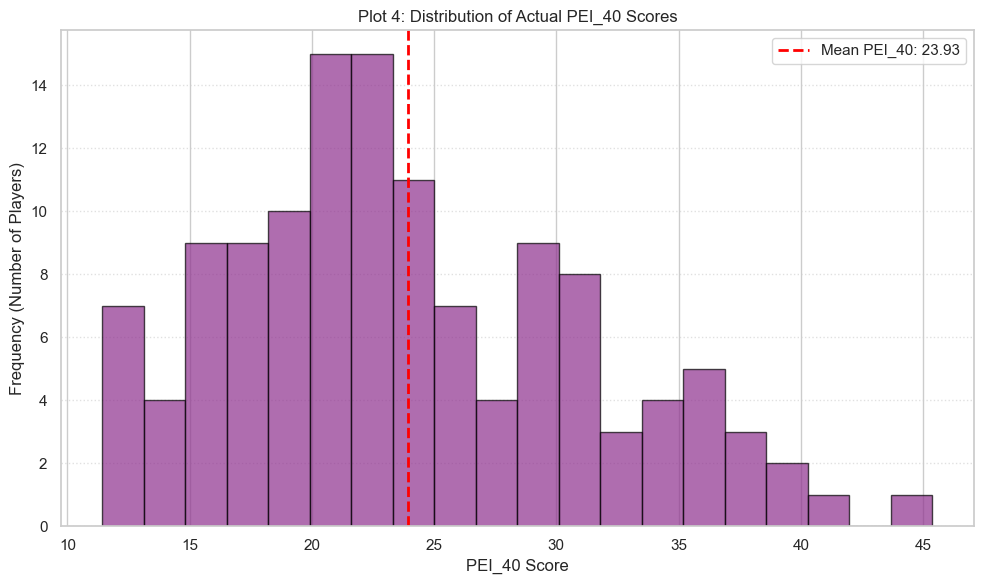


--- All visualizations complete. ---


In [46]:
# ========================================================================= 3RD DELIVERABLE: VISUALIZATION AND PLOTTING (CONTINUATION) ====================================================

print("--- Starting Model Visualization ---")

# Predict on the entire dataset
y_all_actual = y.values
y_all_pred = pipeline.predict(X)

# --- PLOT 1: Actual vs. Predicted PEI_40 ---
def plot_actual_vs_predicted(y_actual, y_predicted):
    """Scatter plot comparing actual vs predicted PEI_40 values."""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_actual, y_predicted, alpha=0.6, color='#0096C7', edgecolors='k')
    min_val = min(min(y_actual), min(y_predicted))
    max_val = max(max(y_actual), max(y_predicted))
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Ideal Prediction Line')
    plt.title('Plot 1: Actual vs. Predicted PEI_40 Score')
    plt.xlabel('Actual PEI_40 Score')
    plt.ylabel('Predicted PEI_40 Score')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

# --- PLOT 2: Residuals Plot ---
def plot_residuals(y_actual, y_predicted):
    """Residual plot: predicted vs residuals (actual - predicted)."""
    residuals = y_actual - y_predicted
    plt.figure(figsize=(10, 6))
    plt.scatter(y_predicted, residuals, alpha=0.6, color='#F6AA1C', edgecolors='k')
    plt.hlines(0, xmin=min(y_predicted), xmax=max(y_predicted), color='red', linestyle='-', label='Zero Residual')
    plt.title('Plot 2: Residuals Plot')
    plt.xlabel('Predicted PEI_40 Score')
    plt.ylabel('Residuals (Actual - Predicted)')
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()

# --- PLOT 3: Feature Importance (Coefficients) ---
def plot_coefficients(features, coefficients_array):
    """Bar chart of model coefficients showing feature impact on PEI_40."""
    coef_df = pd.DataFrame({'Feature': features, 'Coefficient': coefficients_array}).sort_values(by='Coefficient', ascending=False)
    colors = ['#1D7C4F' if c > 0 else '#C70039' for c in coef_df['Coefficient']]
    plt.figure(figsize=(12, 6))
    plt.bar(coef_df['Feature'], coef_df['Coefficient'], color=colors, edgecolor='k')
    plt.title('Plot 3: Feature Importance (Model Coefficients)')
    plt.xlabel('Statistical Feature')
    plt.ylabel('Coefficient Value (Impact on PEI_40)')
    plt.axhline(0, color='black', linewidth=0.8)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle=':', alpha=0.7)
    plt.tight_layout()
    plt.show()

# --- PLOT 4: Distribution of Actual PEI_40 ---
def plot_histogram(pei_data):
    """Histogram of actual PEI_40 scores with mean line."""
    plt.figure(figsize=(10, 6))
    plt.hist(pei_data, bins=20, color='#8E2F8E', edgecolor='black', alpha=0.7)
    mean_pei = np.mean(pei_data)
    plt.axvline(mean_pei, color='red', linestyle='dashed', linewidth=2, label=f'Mean PEI_40: {mean_pei:.2f}')
    plt.title('Plot 4: Distribution of Actual PEI_40 Scores')
    plt.xlabel('PEI_40 Score')
    plt.ylabel('Frequency (Number of Players)')
    plt.legend()
    plt.grid(axis='y', linestyle=':', alpha=0.6)
    plt.tight_layout()
    plt.show()

# Execute plotting functions
plot_actual_vs_predicted(y_all_actual, y_all_pred)
plot_residuals(y_all_actual, y_all_pred)
plot_coefficients(FEATURE_X, fitted_model.coef_)
plot_histogram(y_all_actual)

print("\n--- All visualizations complete. ---")


In [47]:
#==================================================== 3RD DELIVERABLE =============================
#================================================= SELECTING ONLY CURRENT UPIKE PLAYERS ROSTER =======================================

EXCEL_HEADER_ROW_INDEX = 0  #where it starts
EXCEL_FILE_PATH = '/Users/denisnunez/Desktop/FALL 26/DS/master_player_analysis_FULL_clean_UPIKE.xlsx'  

# Outcome 4a – Accessing files for input
#read it 
df = pd.read_excel(EXCEL_FILE_PATH, header=EXCEL_HEADER_ROW_INDEX)


df_upike_2024_25 = df[df['Team_Sheet'] == '2024-25 UPIKE']


rows_to_drop = [77, 79, 80, 82, 83, 85, 86]  # example index numbers
df_upike_2024_25 = df_upike_2024_25.drop(rows_to_drop)
df_upike_2024_25


# Outcome 4a – Accessing files for input
#save evrything to a knew file:
df_upike_2024_25.to_csv('upike_2024_25_players.csv', index=False)

 
df_upike_2024_25_sorted = df_upike_2024_25.sort_values(by='USG%', ascending=False)
print(df_upike_2024_25_sorted)
 





     #           Player_Name Position  GP  GS   MIN  MIN_AVG   FG  FGA    FG%  \
75   2          Stone, Allie        G  28  28  1012     36.1  210  424  0.495   
76   1          Bush, Rachel        F  28  28   841     30.0  155  300  0.517   
78  10      Warren, Jaaliyah        G  28   1   555     19.8   85  191  0.445   
84   3      McKenzie, Taylor        G   8   0    38      4.8    1    7  0.143   
81   4  Mejia-Andrade, Jaidy        F  28  28   733     26.2   57  154  0.370   

    ...     PEI_40        TS%       USG%       AST%       REB%      TOV%  \
75  ...  31.660079  63.417060  26.645173  22.014249   4.137196  2.319076   
76  ...  33.959572  60.130758  23.443568  11.976463  10.637565  3.215270   
78  ...  22.486486  58.853634  22.007403  12.066186   3.233271  4.044803   
84  ...  10.526316  14.285714  14.768851   8.294347   0.346357  5.370491   
81  ...  21.446112  38.787879  14.199198  13.336052   8.003657  2.714553   

        STL%     BLK %  STOCKS     Team_Sheet  
75  1.41

PEI_40 Player Performance Simulator


Load Player by Name (L) or Use Baseline Stats (B)? [L/B]:  B


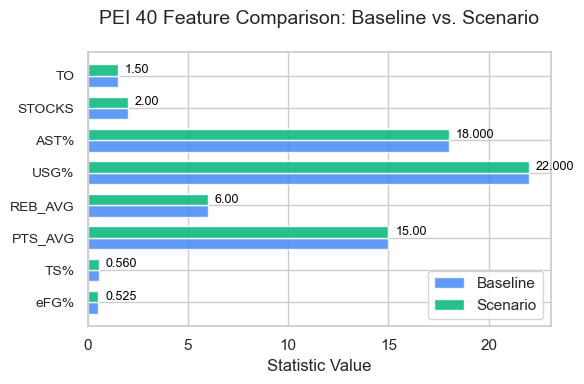


             PEI_40 SIMULATION RESULTS
--- Player: Baseline Model ---
  Initial Calculated PEI_40 Score: 25.32
  Projected PEI_40 Score: 25.32
  Change from Initial: +0.00



Start simulation or Exit? (Type 'EXIT' or Press ENTER to Continue):  exit


Simulator closed. Goodbye!


In [48]:
# ========================================================================= 4TH DELIVERABLE PART 1: FEATURE COMPARISON SIMULATOR =========================================================================



#-----------------Configuration and Constants ---------------------------

# The script requires the 'upike_2024_25_players.csv' file to be accessible 
# (e.g., in the same directory as the Jupyter Notebook or Python script).
INPUT_PLAYER_DATA_FILE = 'upike_2024_25_players.csv' 

# This is the file name where the Matplotlib chart will be saved.
GRAPH_OUTPUT_FILE = 'pei_comparison_graph.png' 


#List of the 8 features required by the PEI_40 model
FEATURE_NAMES = [
    'eFG%', 'TS%', 'PTS_AVG', 'REB_AVG', 'USG%', 'AST%', 'STOCKS', 'TO'
]

#-------------------------RIDGE REGRESSION PARAMETERS (Model coefficients and intercept) -------------------------

# These values were learned during model training and are treated as constants
RIDGE_INTERCEPT = 23.974705260160945 

#Coefficients corresponding to each feature in FEATURE_NAMES
RIDGE_COEFFICIENTS = np.array([
    1.22788348,   # eFG%
    1.26994496,   # TS%
    -0.90618407,  # PTS_AVG
    3.09267188,   # REB_AVG
    4.38962181,   # USG%
    1.40563505,   # AST%
    1.87018104,   # STOCKS
    -2.75769986   # TO
])

#------------------------- STANDARD SCALER PARAMETERS (Mean and Standard Deviation for normalization) ---------------------------------

#These values are used to normalize input features before prediction


SCALER_MEAN = np.array([
    0.37218429, 51.3217026, 7.26900862, 3.59183142, 19.30783307, 
    12.13498157, 33.66336634, 37.75247525
])

SCALER_STD = np.array([
    0.09986462, 8.85265776, 4.81778203, 2.56029091, 4.9013158, 
    6.46709223, 25.67168075, 25.53018246
])

# Default stats used for "Baseline Mode" or if a player's stat is missing
BASELINE_STATS = collections.OrderedDict([
    ('eFG%', 0.525), ('TS%', 0.560), ('PTS_AVG', 15.0), ('REB_AVG', 6.0), 
    ('USG%', 22.0), ('AST%', 18.0), ('STOCKS', 2.0), ('TO', 1.5)
])

#-------------------------  UTILITY FUNCTIONS ------------------------- 

 
def load_player_stats(player_name, required_features):
    """
    Loads stats for a specific player from the CSV file based on name search.
    Returns: An OrderedDict of the 8 features and a dictionary of player info.
    """
    try:
        df = pd.read_csv(INPUT_PLAYER_DATA_FILE)
    except FileNotFoundError:
        print(f"Error: Data file not found at '{INPUT_PLAYER_DATA_FILE}'. Cannot load player.")
        return None, None

    # Case-insensitive search for the player name
    player_row = df[df['Player_Name'].str.contains(player_name, case=False, na=False)]
    
    if player_row.empty:
        print(f"Player '{player_name}' not found in the dataset.")
        return None, None
    
    stats_series = player_row.iloc[0]
    player_stats = collections.OrderedDict()
    
    # Extract and convert required features
    for feature in required_features:
        value = stats_series.get(feature)
        try:
            player_stats[feature] = float(value)
        except (ValueError, TypeError):
            # Fallback to baseline value if data is missing or invalid
            player_stats[feature] = BASELINE_STATS.get(feature, 0.0)
     
    player_info = {
        'Name': stats_series.get('Player_Name', player_name),
        'Original_PEI_40': float(stats_series.get('PEI_40', 0.0))
    }
    
    print(f"\n--- Successfully Loaded Stats for: {player_info['Name']} ---")
    
    # Ensure the final output is ordered correctly
    final_stats = collections.OrderedDict()
    for feature in required_features:
        final_stats[feature] = player_stats[feature]

    return final_stats, player_info

 
def calculate_pei(raw_stats_dict):
    """
    Calculates the predicted PEI_40 score using the standardized Ridge Regression model.
    """
    
    # 1. Convert stats to NumPy array in the correct order
    raw_stats_array = np.array([raw_stats_dict[name] for name in FEATURE_NAMES])
    
    # 2. Standardize the features: Z = (X - µ) / σ
    standardized_stats = (raw_stats_array - SCALER_MEAN) / SCALER_STD
    
    # 3. Calculate the weighted sum (dot product)
    weighted_sum = np.dot(RIDGE_COEFFICIENTS, standardized_stats)
    
    # 4. Final Prediction: Intercept + Weighted Sum
    predicted_pei = RIDGE_INTERCEPT + weighted_sum
    
    return predicted_pei

 
#-------------------------  Matplotlib Graphing Function ------------------------- 


def generate_comparison_graph(baseline_stats, scenario_stats):
    """
    Generates a Matplotlib horizontal bar chart comparing the 8 features 
    between the initial Baseline and the modified Scenario, then saves it.
    """
    
    labels = [
    'eFG%', 'TS%', 'PTS_AVG', 'REB_AVG', 'USG%', 'AST%', 'STOCKS', 'TO'
]

    baseline_values = [baseline_stats[name] for name in labels]
    scenario_values = [scenario_stats[name] for name in labels]
    
    # Setup plot dimensions and bar positions
    y = np.arange(len(labels))
    height = 0.35
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Create the bars
    ax.barh(y - height/2, baseline_values, height, label='Baseline', color='#3b82f6', alpha=0.8)
    ax.barh(y + height/2, scenario_values, height, label='Scenario', color='#10b981', alpha=0.9)
    
    # Configure axes and title
    ax.set_xlabel('Statistic Value', fontsize=12)
    ax.set_title('PEI 40 Feature Comparison: Baseline vs. Scenario', fontsize=14, pad=20)
    ax.set_yticks(y)
    ax.set_yticklabels(labels, fontsize=10)
    ax.legend(loc='lower right')
    
    # Add value labels to the scenario bars
    for i, name in enumerate(labels):
        # Use different formatting for percentages (3 decimal places) vs counts/averages (2 decimal places)
        is_percent = name.endswith('%') or name == 'eFG%'
        value_text = f'{scenario_values[i]:.3f}' if is_percent else f'{scenario_values[i]:.2f}'
        
        ax.annotate(
            value_text,
            xy=(scenario_values[i], y[i] + height/2),
            xytext=(5, 0),
            textcoords="offset points",
            ha='left', 
            va='center',
            fontsize=9,
            color='black'
        )
    
    fig.tight_layout()
    plt.show()

    
    
   


def get_user_input(current_stats, initial_run=False):
    """
    Prompts the user to enter new values for each feature in the console/Jupyter.
    """
    new_stats = current_stats.copy()
    
    if initial_run:
        initial_input = input("\nStart simulation or Exit? (Type 'EXIT' or Press ENTER to Continue): ").strip().upper()
    else:
        print("\n--- Enter New Player Stats for What-If Scenario ---")
        initial_input = input("Continue editing, or Exit? (Type 'EXIT' or Press ENTER to Continue): ").strip().upper()

    if initial_input == 'EXIT':
        return None 
    
    print("Press ENTER to keep the current value for a stat.")
    
    for name, current_value in current_stats.items():
        while True:
            # Determine formatting for display
            format_str = f"{current_value:.3f}" if name.endswith('%') or name == 'eFG%' else f"{current_value:.2f}"
                
            prompt = f"Enter value for {name} (Current: {format_str}): "
            
            user_input = input(prompt).strip()
            
            if not user_input:
                break
            
            try:
                new_value = float(user_input)
                new_stats[name] = new_value
                break
            except ValueError:
                print("Invalid input. Please enter a number or press Enter.")
                
    return new_stats

def print_results(baseline_pei, projected_pei, player_info):
    """
    Prints the resulting PEI scores to the console.
    """
    print("\n" + "="*50)
    print("             PEI_40 SIMULATION RESULTS")
    print("="*50)
    
    player_name = player_info.get('Name')
    original_pei = player_info.get('Original_PEI_40')

    if player_name:
        print(f"--- Player: {player_name} ---")
        if original_pei is not None:
             print(f"--- Actual PEI_40 from CSV: {original_pei:.2f} ---")
    else:
        print("--- Player: Baseline Model ---")

    print(f"  Initial Calculated PEI_40 Score: {baseline_pei:.2f}")
    
    change = projected_pei - baseline_pei
    print(f"  Projected PEI_40 Score: {projected_pei:.2f}")
    change_sign = "+" if change >= 0 else ""
    print(f"  Change from Initial: {change_sign}{change:.2f}")
    
  

#------------------------------------------------ MAIN APPLICATION LOGIC ------------------------------------------------
 
def main():
    """
    Main loop for the console/Jupyter application.
    """
    
    player_info = {'Name': None, 'Original_PEI_40': None}
    BASE_STATS = None # Placeholder for the player's initial stats
    
    print("="*50)
    print("PEI_40 Player Performance Simulator")
    print("="*50)
    
    # --- Initial Player Loading/Selection ---
    while BASE_STATS is None:
        mode_choice = input("Load Player by Name (L) or Use Baseline Stats (B)? [L/B]: ").strip().upper()
        
        if mode_choice == 'L':
            player_name = input("Enter the Player Name to load (Last Name, First Name): ").strip()
            initial_stats, info = load_player_stats(player_name, FEATURE_NAMES)
            
            if initial_stats:
                BASE_STATS = initial_stats.copy()
                player_info = info
                break
        
        elif mode_choice == 'B':
            BASE_STATS = BASELINE_STATS.copy()
            player_info['Name'] = 'Baseline Model'
            player_info['Original_PEI_40'] = None
            break
            
        else:
            print("Invalid choice. Please enter 'L' to Load or 'B' for Baseline.")
            
    
    #Calculate the score for the initial baseline player once
    baseline_pei = calculate_pei(BASE_STATS)
    current_stats = BASE_STATS.copy() # Current stats start equal to baseline

    #Start if the simulation loop
    while True:
        # Calculate the projected PEI based on the current scenario stats
        projected_pei = calculate_pei(current_stats)
        
        # Generate and save the Matplotlib graph
        generate_comparison_graph(BASE_STATS, current_stats)
    

        # Display the text results
        print_results(baseline_pei, projected_pei, player_info)

        # Get the next set of user inputs
        is_initial_run = (current_stats == BASE_STATS)
        
        next_stats = get_user_input(current_stats, initial_run=is_initial_run)
        
        if next_stats is None:
            print("Simulator closed. Goodbye!")
            break 
        
        # Update current stats for the next iteration
        current_stats = next_stats
        print("\nCalculating new projection...")

if __name__ == "__main__":
    try:
        main()
    except KeyboardInterrupt:
        print("\nSimulator closed by Keyboard Interrupt. Goodbye!")
    except Exception as e:
        print(f"\nAn unexpected error occurred. Error: {e}")

In [52]:
# ========================================================================= 4TH DELIVERABLE PART 2: LINEUP SIMULATOR =========================================================================


INPUT_PLAYER_DATA_FILE = 'upike_2024_25_players.csv' 


#Min requirements for a basketball team
MIN_GUARDS = 2
MIN_FORWARDS = 2
LINEUP_SIZE = 5



#----------------------------------------------- ROLE DETERMINATION LOGIC  -----------------------------


def determine_roles(pos):
    """
    Determines whether a player qualifies as a guard and/or forward
    based on the position string from the dataset.
    
    Returns:
        (bool, bool): (is_guard, is_forward)
    """
    
    if pd.isna(pos):
        return (False, False)
        
    pos_upper = str(pos).strip().upper()
    is_guard = 'G' in pos_upper
    is_forward = 'F' in pos_upper or 'C' in pos_upper
    return (is_guard, is_forward)


# ----------------------------------------------- LINEUP OPTIMIZATION MODEL -----------------------------------------------

def optimize_lineup_scipy():
    """
    Optimizes a starting lineup of five players by maximizing total PEI_40,
    subject to minimum guard and forward constraints.
    """

    try:
        df = pd.read_csv(INPUT_PLAYER_DATA_FILE)
    except FileNotFoundError:
        print(f"ERROR: File not found at '{INPUT_PLAYER_DATA_FILE}'.")
        return

    #Load and clean player data
    df['Player_Name'] = df['Player_Name'].str.strip()
    df['PEI_40'] = pd.to_numeric(df['PEI_40'], errors='coerce').fillna(0)

    #Determine positional eligibility
    df[['Is_Guard', 'Is_Forward']] = (
        df['Position'].apply(determine_roles).apply(pd.Series)
    )
    
    #Filter eligible players
    df_eligible = df[df['PEI_40'] > 0].reset_index(drop=True)

    if df_eligible.empty:
        print("ERROR: No eligible players with PEI_40 > 0.")
        return

    # Create hypothetical player
    guard_peis = df_eligible[df_eligible['Is_Guard']]['PEI_40']
    hypothetical_pei = guard_peis.mean() if not guard_peis.empty else 20.0

    print("-" * 70)
    print(f"Avg PEI-40 for Guards: {hypothetical_pei:.2f}")
    print("Injecting 'Hypothetical Starter G'.")
    print("-" * 70)

    df_eligible.loc[len(df_eligible)] = {
        'Player_Name': 'Hypothetical Starter G',
        'Position': 'G',
        'PEI_40': hypothetical_pei,
        'Is_Guard': True,
        'Is_Forward': False
    }

    # --------------------------------- OPTIMIZATION MODEL SETUP --------------------------
    N = len(df_eligible)

    # Objective: maximize PEI --- minimize negative PEI
    c = -df_eligible['PEI_40'].values
    bounds = [(0, 1)] * N
    integrality = [1] * N

    # Lineup size constraints
    A_eq = np.ones((1, N))
    b_eq = np.array([LINEUP_SIZE])

    #Positional constraints
    guard_vector = df_eligible['Is_Guard'].astype(int).values
    forward_vector = df_eligible['Is_Forward'].astype(int).values

    A_ub = np.vstack([-guard_vector, -forward_vector])
    b_ub = np.array([-MIN_GUARDS, -MIN_FORWARDS])

    # Solve MILP
    print("Solving with SciPy 'highs' MILP solver...")
    result = linprog(
        c,
        A_ub=A_ub,
        b_ub=b_ub,
        A_eq=A_eq,
        b_eq=b_eq,
        bounds=bounds,
        integrality=integrality,
        method='highs'
    )

    print("="*70)
    print("        FINAL OPTIMAL STARTING LINEUP (MAXIMUM PEI-40)")
    print("="*70)

    if not result.success:
        print(f"FAILED: {result.message}")
        return

    #------------------------------------ Extract and Display Optimal Lineup 

    selected_indices = np.where(np.round(result.x) == 1)[0]

    optimal_lineup = []
    for i in selected_indices:
        player = df_eligible.loc[i]
        optimal_lineup.append({
            'Name': player['Player_Name'],
            'Position': player['Position'],
            'PEI_40': player['PEI_40']
        })

    total_pei = -result.fun
    lineup_df = pd.DataFrame(optimal_lineup).sort_values(by='PEI_40', ascending=False)
    lineup_df['PEI_40'] = lineup_df['PEI_40'].apply(lambda x: float(f"{x:.2f}"))

    # Regular printed version
    print(lineup_df.to_string(index=False))
    print("="*70)

    # --------------------------------------- Styled Output Table ------------------------------
    
    styled_table = (
        lineup_df.style
            .set_caption("Optimal Starting Lineup (Max PEI-40)")
            .set_table_styles([
                {'selector': 'caption',
                 'props': [('font-size', '18px'),
                           ('font-weight', 'bold'),
                           ('text-align', 'center'),
                           ('color', '#333')]},
                {'selector': 'th',
                 'props': [('background-color', '#1E88E5'),
                           ('color', 'white'),
                           ('font-size', '14px'),
                           ('padding', '8px')]},
                {'selector': 'td',
                 'props': [('font-size', '13px'),
                           ('padding', '6px'),
                           ('border', '0.5px solid #ccc')]},
                {'selector': 'tbody tr:nth-child(even)',
                 'props': [('background-color', '#F5F5F5')]}
            ])
            .format({'PEI_40': '{:.2f}'})
    )

    display(styled_table)  


#--------------------------------------- EXECUTION --------------------------------------


optimize_lineup_scipy()


----------------------------------------------------------------------
Avg PEI-40 for Guards: 21.56
Injecting 'Hypothetical Starter G'.
----------------------------------------------------------------------
Solving with SciPy 'highs' MILP solver...
        FINAL OPTIMAL STARTING LINEUP (MAXIMUM PEI-40)
                  Name Position  PEI_40
          Bush, Rachel        F   33.96
          Stone, Allie        G   31.66
      Warren, Jaaliyah        G   22.49
Hypothetical Starter G        G   21.56
  Mejia-Andrade, Jaidy        F   21.45


,Name,Position,PEI_40
1,"Bush, Rachel",F,33.96
0,"Stone, Allie",G,31.66
2,"Warren, Jaaliyah",G,22.49
4,Hypothetical Starter G,G,21.56
3,"Mejia-Andrade, Jaidy",F,21.45
